In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import climlab
from climlab.radiation import RRTMG
from scipy import interpolate
from scipy.interpolate import griddata
import cartopy.crs as ccrs

In [2]:
#from lecture
#sets up the Slab Ocean Model and Coupled Model
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }

basepath = '/roselab_rit/cesm_archive/'
#basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/' 

casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'   
    
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path, decode_times=False)

Attempting to open the dataset  /roselab_rit/cesm_archive/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  /roselab_rit/cesm_archive/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  /roselab_rit/cesm_archive/som_1850_f19/concatenated/som_1850_f19.cam.h0.nc
Attempting to open the dataset  /roselab_rit/cesm_archive/som_1850_2xCO2/concatenated/som_1850_2xCO2.cam.h0.nc


In [3]:
#scaling variables for cesm models
som_q_control = atm['som_control'].Q.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

mlon = som_q_control.lon
mlat = som_q_control.lat
mlev = som_q_control.lev

#weighting factor for averaging over vertical axis
lw = np.log(mlev)
mw = np.cos(np.deg2rad(mlat))

In [4]:
#print(mlev)
#print(mlat)

# Kernels

In [5]:
###CAM3 kernels###
#sw albedo kernels (3D)
albedo_sw_clr_d = xr.open_dataset('Data/CAM3_albedo_sw_clr_kernel.nc') #clr means clear sky
albedo_sw_d = xr.open_dataset('Data/CAM3_albedo_sw_kernel.nc') #all-sky

#temp profile kernels (4D)
planck_lw_clr_d = xr.open_dataset('Data/CAM3_planck_lw_clr_kernel.nc')
planck_lw_d = xr.open_dataset('Data/CAM3_planck_lw_kernel.nc')

#surface temp kernels (3D)
surft_lw_clr_d = xr.open_dataset('Data/CAM3_surft_lw_clr_kernel.nc')
surft_lw_d = xr.open_dataset('Data/CAM3_surft_lw_kernel.nc')

#water vapor kernels (4D)
wv_lw_clr_d = xr.open_dataset('Data/CAM3_wv_lw_clr_kernel.nc')
wv_lw_d = xr.open_dataset('Data/CAM3_wv_lw_kernel.nc')
wv_sw_clr_d = xr.open_dataset('Data/CAM3_wv_sw_clr_kernel.nc')
wv_sw_d = xr.open_dataset('Data/CAM3_wv_sw_kernel.nc')

#help(surft_lw_clr_d)

#scaling variables for kernels
#print(surft_lw_d.attrs)
lat = albedo_sw_clr_d.lat[:]
lon = albedo_sw_clr_d.lon[:]
lev = wv_lw_clr_d.lev[:]
w = np.cos(np.deg2rad(lat))
klw = np.log(lev)

In [6]:
#from Brian Rose
def interp(lat1, lev1, data, lat2, lev2):
    '''A general purpose interpolation routine for transforming
    between two different latitude - pressure level grids.'''
    nlat = lat2.size
    nlev = lev2.size
    X1, Y1 = np.meshgrid(lat1, lev1)
    X2, Y2 = np.meshgrid(lat2, lev2)
    #print('X1: ',X1)
    #print('X2: ',X2)
    points_in = np.transpose(np.array([X1.flatten(), Y1.flatten()]))
    #print('in: ',points_in)
    points_out = np.transpose(np.array([X2.flatten(), Y2.flatten()]))
    #print('out: ',points_out)
    data_interp = griddata(points_in, data.flatten(),points_out, method='linear').reshape(nlev, nlat)
    return data_interp



In [7]:
#from lecture
gw = atm['som_control'].gw
def globalMean(field, weight=gw):
    '''Return the area-weighted global average of the input field'''
    return (field*weight).mean(dim=('lat','lon'))/weight.mean(dim='lat')

def maskGlobalMean(d,w):
    "computes global mean of the regridded data (lat,lon). It deals with nans contained within an array"
    md = np.ma.masked_array(d, np.isnan(d))
    test = np.ma.average(np.ma.average(md,axis=0,weights = w))
    return test

def globalMeanInterp(d,w,lw):
    "computes global mean of the regridded data (lev,lat). It deals with nans contained within an array"
    md = np.ma.masked_array(d, np.isnan(d))
    test = np.ma.average(np.ma.average(md,axis=1,weights = w),weights=lw)
    return test

#plt.contourf(mlat,wv_lw_d.lev,test,cmap="seismic",vmin=-0.35,vmax=0.35)
#plt.colorbar()
#plt.gca().invert_yaxis()

In [8]:
#from lecture
def make_map(field,label):
    '''input field should be a 2D xarray.DataArray on a lat/lon grid.
        Make a filled contour plot of the field, and a line plot of the zonal mean
    '''
    fig = plt.figure(figsize=(14,6))
    nrows = 10; ncols = 3
    mapax = plt.subplot2grid((nrows,ncols), (0,0), colspan=ncols-1, rowspan=nrows-1, projection=ccrs.Robinson())
    barax = plt.subplot2grid((nrows,ncols), (nrows-1,0), colspan=ncols-1)
    plotax = plt.subplot2grid((nrows,ncols), (0,ncols-1), rowspan=nrows-1)
    cx = mapax.contourf(mlon, mlat, field, transform=ccrs.PlateCarree())
    mapax.set_global(); mapax.coastlines();
    plt.colorbar(cx, cax=barax, orientation='horizontal',label=label)
    plotax.plot(np.meshgrid(mlon,mlat)[1])
    plotax.set_ylabel('Latitude')
    plotax.grid()
    return fig, (mapax, plotax, barax), cx

In [9]:
#converts kernels to arrays
albedo_sw_clr = xr.open_dataset('Data/CAM3_albedo_sw_clr_kernel.nc').to_array()[0]
albedo_sw = xr.open_dataset('Data/CAM3_albedo_sw_kernel.nc').to_array()[0]
planck_lw_clr = xr.open_dataset('Data/CAM3_planck_lw_clr_kernel.nc').to_array()[0]
planck_lw = xr.open_dataset('Data/CAM3_planck_lw_kernel.nc').to_array()[0]
surft_lw_clr = xr.open_dataset('Data/CAM3_surft_lw_clr_kernel.nc').to_array()[0]
surft_lw = xr.open_dataset('Data/CAM3_surft_lw_kernel.nc').to_array()[0]
wv_lw_clr = xr.open_dataset('Data/CAM3_wv_lw_clr_kernel.nc').to_array()[0]
wv_lw = xr.open_dataset('Data/CAM3_wv_lw_kernel.nc').to_array()[0]
wv_sw_clr = xr.open_dataset('Data/CAM3_wv_sw_clr_kernel.nc').to_array()[0]
wv_sw = xr.open_dataset('Data/CAM3_wv_sw_kernel.nc').to_array()[0]

seasons

In [10]:
#kernel winter average
w_albedo_sw = np.average(albedo_sw[0:2]+albedo_sw[11],axis=0) #64x128
w_albedo_sw_clr = np.average(albedo_sw_clr[0:1]+albedo_sw_clr[11],axis=0) #64x128
w_planck_lw = np.average(planck_lw[0:2]+planck_lw[11],axis=0) #17x64x128
w_planck_lw_clr = np.average(planck_lw_clr[0:2]+planck_lw_clr[11],axis=0) #17x64x128
w_surft_lw = np.average(surft_lw[0:2]+surft_lw[11],axis=0) #64x128
w_surft_lw_clr = np.average(surft_lw_clr[0:2]+surft_lw_clr[11],axis=0) #64x128
w_q_lw = np.average(wv_lw[0:2]+wv_lw[11],axis=0) #17x64x128
w_q_lw_clr = np.average(wv_lw_clr[0:2]+wv_lw_clr[11],axis=0) #17x64x128
w_q_sw = np.average(wv_sw[0:2]+wv_sw[11],axis=0) #17x64x128
w_q_sw_clr = np.average(wv_sw_clr[0:2]+wv_sw_clr[11],axis=0) #17x64x128

In [11]:
#kernel spring average
sp_albedo_sw = np.average(albedo_sw[2:5],axis=0) #64x128
sp_albedo_sw_clr = np.average(albedo_sw_clr[2:5],axis=0) #64x128
sp_planck_lw = np.average(planck_lw[2:5],axis=0) #17x64x128
sp_planck_lw_clr = np.average(planck_lw_clr[2:5],axis=0) #17x64x128
sp_surft_lw = np.average(surft_lw[2:5],axis=0) #64x128
sp_surft_lw_clr = np.average(surft_lw_clr[2:5],axis=0) #64x128
sp_q_lw = np.average(wv_lw[2:5],axis=0) #17x64x128
sp_q_lw_clr = np.average(wv_lw_clr[2:5],axis=0) #17x64x128
sp_q_sw = np.average(wv_sw[2:5],axis=0) #17x64x128
sp_q_sw_clr = np.average(wv_sw_clr[2:5],axis=0) #17x64x128

In [12]:
#kernel summer average
su_albedo_sw = np.average(albedo_sw[5:8],axis=0) #64x128
su_albedo_sw_clr = np.average(albedo_sw_clr[5:8],axis=0) #64x128
su_planck_lw = np.average(planck_lw[5:8],axis=0) #17x64x128
su_planck_lw_clr = np.average(planck_lw_clr[5:8],axis=0) #17x64x128
su_surft_lw = np.average(surft_lw[5:8],axis=0) #64x128
su_surft_lw_clr = np.average(surft_lw_clr[5:8],axis=0) #64x128
su_q_lw = np.average(wv_lw[5:8],axis=0) #17x64x128
su_q_lw_clr = np.average(wv_lw_clr[5:8],axis=0) #17x64x128
su_q_sw = np.average(wv_sw[5:8],axis=0) #17x64x128
su_q_sw_clr = np.average(wv_sw_clr[5:8],axis=0) #17x64x128

In [13]:
#kernel fall average
f_albedo_sw = np.average(albedo_sw[8:11],axis=0) #64x128
f_albedo_sw_clr = np.average(albedo_sw_clr[8:11],axis=0) #64x128
f_planck_lw = np.average(planck_lw[8:11],axis=0) #17x64x128
f_planck_lw_clr = np.average(planck_lw_clr[8:11],axis=0) #17x64x128
f_surft_lw = np.average(surft_lw[8:11],axis=0) #64x128
f_surft_lw_clr = np.average(surft_lw_clr[8:11],axis=0) #64x128
f_q_lw = np.average(wv_lw[8:11],axis=0) #17x64x128
f_q_lw_clr = np.average(wv_lw_clr[8:11],axis=0) #17x64x128
f_q_sw = np.average(wv_sw[8:11],axis=0) #17x64x128
f_q_sw_clr = np.average(wv_sw_clr[8:11],axis=0) #17x64x128

Regrid 2D

In [14]:
#regridding of 2d winter kernels (after time average) to (lat,lon)
i_w_a_sw = interp(lon,lat,w_albedo_sw,mlon,mlat)
i_w_a_sw_clr = interp(lon,lat,w_albedo_sw_clr,mlon,mlat)
i_w_st_lw = interp(lon,lat,w_surft_lw,mlon,mlat)
i_w_st_lw_clr = interp(lon,lat,w_surft_lw_clr,mlon,mlat)

In [15]:
#regridding of 2d spring kernels (after time average) to (lat,lon)
i_sp_a_sw = interp(lon,lat,sp_albedo_sw,mlon,mlat)
i_sp_a_sw_clr = interp(lon,lat,sp_albedo_sw_clr,mlon,mlat)
i_sp_st_lw = interp(lon,lat,sp_surft_lw,mlon,mlat)
i_sp_st_lw_clr = interp(lon,lat,sp_surft_lw_clr,mlon,mlat)

In [16]:
#regridding of 2d summer kernels (after time average) to (lat,lon)
i_su_a_sw = interp(lon,lat,su_albedo_sw,mlon,mlat)
i_su_a_sw_clr = interp(lon,lat,su_albedo_sw_clr,mlon,mlat)
i_su_st_lw = interp(lon,lat,su_surft_lw,mlon,mlat)
i_su_st_lw_clr = interp(lon,lat,su_surft_lw_clr,mlon,mlat)

In [17]:
#regridding of 2d full kernels (after time average) to (lat,lon)
i_f_a_sw = interp(lon,lat,f_albedo_sw,mlon,mlat)
i_f_a_sw_clr = interp(lon,lat,f_albedo_sw_clr,mlon,mlat)
i_f_st_lw = interp(lon,lat,f_surft_lw,mlon,mlat)
i_f_st_lw_clr = interp(lon,lat,f_surft_lw_clr,mlon,mlat)

Regrid 2D (lev,lat)

In [18]:
#regridding the 3D Winter data (after time average)
#regrids to (lev,lat)
w_p_lw = np.average(w_planck_lw,axis=2)
w_pc_lw = np.average(w_planck_lw_clr,axis=2)
w_wv_lw = np.average(w_q_lw,axis=2)
w_wvc_lw = np.average(w_q_lw_clr,axis=2)
w_wv_sw = np.average(w_q_sw,axis=2)
w_wvc_sw = np.average(w_q_sw_clr,axis=2)

w_plat_p_lw = interp(lat,lev,w_p_lw,mlat,mlev)
w_plat_p_lw_clr = interp(lat,lev,w_pc_lw,mlat,mlev)
w_plat_wv_lw = interp(lat,lev,w_wv_lw,mlat,mlev)
w_plat_wv_lw_clr = interp(lat,lev,w_wvc_lw,mlat,mlev)
w_plat_wv_sw = interp(lat,lev,w_wv_sw,mlat,mlev)
w_plat_wv_sw_clr = interp(lat,lev,w_wvc_sw,mlat,mlev)

In [19]:
#regridding the 3D Spring data (after time average)
#regrids to (lev,lat)
sp_p_lw = np.average(sp_planck_lw,axis=2)
sp_pc_lw = np.average(sp_planck_lw_clr,axis=2)
sp_wv_lw = np.average(sp_q_lw,axis=2)
sp_wvc_lw = np.average(sp_q_lw_clr,axis=2)
sp_wv_sw = np.average(sp_q_sw,axis=2)
sp_wvc_sw = np.average(sp_q_sw_clr,axis=2)

sp_plat_p_lw = interp(lat,lev,sp_p_lw,mlat,mlev)
sp_plat_p_lw_clr = interp(lat,lev,sp_pc_lw,mlat,mlev)
sp_plat_wv_lw = interp(lat,lev,sp_wv_lw,mlat,mlev)
sp_plat_wv_lw_clr = interp(lat,lev,sp_wvc_lw,mlat,mlev)
sp_plat_wv_sw = interp(lat,lev,sp_wv_sw,mlat,mlev)
sp_plat_wv_sw_clr = interp(lat,lev,sp_wvc_sw,mlat,mlev)

In [20]:
#regridding the 3D Summer data (after time average)
#regrids to (lev,lat)
su_p_lw = np.average(su_planck_lw,axis=2)
su_pc_lw = np.average(su_planck_lw_clr,axis=2)
su_wv_lw = np.average(su_q_lw,axis=2)
su_wvc_lw = np.average(su_q_lw_clr,axis=2)
su_wv_sw = np.average(su_q_sw,axis=2)
su_wvc_sw = np.average(su_q_sw_clr,axis=2)

su_plat_p_lw = interp(lat,lev,su_p_lw,mlat,mlev)
su_plat_p_lw_clr = interp(lat,lev,su_pc_lw,mlat,mlev)
su_plat_wv_lw = interp(lat,lev,su_wv_lw,mlat,mlev)
su_plat_wv_lw_clr = interp(lat,lev,su_wvc_lw,mlat,mlev)
su_plat_wv_sw = interp(lat,lev,su_wv_sw,mlat,mlev)
su_plat_wv_sw_clr = interp(lat,lev,su_wvc_sw,mlat,mlev)

In [21]:
#regridding the 3D Fall data (after time average)
#regrids to (lev,lat)
f_p_lw = np.average(f_planck_lw,axis=2)
f_pc_lw = np.average(f_planck_lw_clr,axis=2)
f_wv_lw = np.average(f_q_lw,axis=2)
f_wvc_lw = np.average(f_q_lw_clr,axis=2)
f_wv_sw = np.average(f_q_sw,axis=2)
f_wvc_sw = np.average(f_q_sw_clr,axis=2)

f_plat_p_lw = interp(lat,lev,f_p_lw,mlat,mlev)
f_plat_p_lw_clr = interp(lat,lev,f_pc_lw,mlat,mlev)
f_plat_wv_lw = interp(lat,lev,f_wv_lw,mlat,mlev)
f_plat_wv_lw_clr = interp(lat,lev,f_wvc_lw,mlat,mlev)
f_plat_wv_sw = interp(lat,lev,f_wv_sw,mlat,mlev)
f_plat_wv_sw_clr = interp(lat,lev,f_wvc_sw,mlat,mlev)

uncomment for plots

In [22]:
#plt.contourf(mlat,mlev,-w_plat_wv_lw,cmap = 'seismic', vmax = 0.3, vmin = -0.3)
#plt.gca().invert_yaxis()
#plt.title('LW WV -F Kernel' )
#plt.colorbar()

In [23]:
#plt.contourf(mlat,mlev,-f_plat_wv_lw,cmap = 'seismic', vmax = 0.3, vmin = -0.3)
#plt.gca().invert_yaxis()
#plt.title('SW WV -F Kernel' )
#plt.colorbar()

regrid 2D (lat,lon)

In [24]:
#regridding the 3D Winter data (after time average)
#regrids to (lat,lon)
w_p_lw = np.average(w_planck_lw,axis=0, weights=klw)
w_pc_lw = np.average(w_planck_lw_clr,axis=0, weights=klw)
w_wv_lw = np.average(w_q_lw,axis=0, weights=klw)
w_wvc_lw = np.average(w_q_lw_clr,axis=0, weights=klw)
w_wv_sw = np.average(w_q_sw,axis=0, weights=klw)
w_wvc_sw = np.average(w_q_sw_clr,axis=0, weights=klw)

w_plon_p_lw = interp(lon,lat,w_p_lw,mlon,mlat)
w_plon_p_lw_clr = interp(lon,lat,w_pc_lw,mlon,mlat)
w_plon_wv_lw = interp(lon,lat,w_wv_lw,mlon,mlat)
w_plon_wv_lw_clr = interp(lon,lat,w_wvc_lw,mlon,mlat)
w_plon_wv_sw = interp(lon,lat,w_wv_sw,mlon,mlat)
w_plon_wv_sw_clr = interp(lon,lat,w_wvc_sw,mlon,mlat)

In [25]:
#regridding the 3D Spring data (after time average)
#regrids to (lat,lon)
sp_p_lw = np.average(sp_planck_lw,axis=0, weights=klw)
sp_pc_lw = np.average(sp_planck_lw_clr,axis=0, weights=klw)
sp_wv_lw = np.average(sp_q_lw,axis=0, weights=klw)
sp_wvc_lw = np.average(sp_q_lw_clr,axis=0, weights=klw)
sp_wv_sw = np.average(sp_q_sw,axis=0, weights=klw)
sp_wvc_sw = np.average(sp_q_sw_clr,axis=0, weights=klw)

sp_plon_p_lw = interp(lon,lat,sp_p_lw,mlon,mlat)
sp_plon_p_lw_clr = interp(lon,lat,sp_pc_lw,mlon,mlat)
sp_plon_wv_lw = interp(lon,lat,sp_wv_lw,mlon,mlat)
sp_plon_wv_lw_clr = interp(lon,lat,sp_wvc_lw,mlon,mlat)
sp_plon_wv_sw = interp(lon,lat,sp_wv_sw,mlon,mlat)
sp_plon_wv_sw_clr = interp(lon,lat,sp_wvc_sw,mlon,mlat)

In [26]:
#regridding the 3D Summer data (after time average)
#regrids to (lat,lon)
su_p_lw = np.average(su_planck_lw,axis=0, weights=klw)
su_pc_lw = np.average(su_planck_lw_clr,axis=0, weights=klw)
su_wv_lw = np.average(su_q_lw,axis=0, weights=klw)
su_wvc_lw = np.average(su_q_lw_clr,axis=0, weights=klw)
su_wv_sw = np.average(su_q_sw,axis=0, weights=klw)
su_wvc_sw = np.average(su_q_sw_clr,axis=0, weights=klw)

su_plon_p_lw = interp(lon,lat,su_p_lw,mlon,mlat)
su_plon_p_lw_clr = interp(lon,lat,su_pc_lw,mlon,mlat)
su_plon_wv_lw = interp(lon,lat,su_wv_lw,mlon,mlat)
su_plon_wv_lw_clr = interp(lon,lat,su_wvc_lw,mlon,mlat)
su_plon_wv_sw = interp(lon,lat,su_wv_sw,mlon,mlat)
su_plon_wv_sw_clr = interp(lon,lat,su_wvc_sw,mlon,mlat)

In [27]:
#regridding the 3D Fall data (after time average)
#regrids to (lat,lon)
f_p_lw = np.average(f_planck_lw,axis=0, weights=klw)
f_pc_lw = np.average(f_planck_lw_clr,axis=0, weights=klw)
f_wv_lw = np.average(f_q_lw,axis=0, weights=klw)
f_wvc_lw = np.average(f_q_lw_clr,axis=0, weights=klw)
f_wv_sw = np.average(f_q_sw,axis=0, weights=klw)
f_wvc_sw = np.average(f_q_sw_clr,axis=0, weights=klw)

f_plon_p_lw = interp(lon,lat,f_p_lw,mlon,mlat)
f_plon_p_lw_clr = interp(lon,lat,f_pc_lw,mlon,mlat)
f_plon_wv_lw = interp(lon,lat,f_wv_lw,mlon,mlat)
f_plon_wv_lw_clr = interp(lon,lat,f_wvc_lw,mlon,mlat)
f_plon_wv_sw = interp(lon,lat,f_wv_sw,mlon,mlat)
f_plon_wv_sw_clr = interp(lon,lat,f_wvc_sw,mlon,mlat)

# CESM Models

indexing cesm runs

Som

In [28]:
#winter indexes
wn = []
for i in range(0,120,12):
    if i == 0:
        wn.append(i)
        wn.append(i+1)
    else:
        wn.append(i-1)
        wn.append(i)
        wn.append(i+1)

#spring indexes
spn = []
for i in range(3,120,12):
    spn.append(i-1)
    spn.append(i)
    spn.append(i+1)
    
#summer indexes
sun = []
for i in range(6,120,12):
    sun.append(i-1)
    sun.append(i)
    sun.append(i+1)
    
#fall indexes
fn = []
for i in range(9,120,12):
    fn.append(i-1)
    fn.append(i)
    fn.append(i+1)

Cpl

In [29]:
#winter indexes
wc = []
for i in range(0,224,12):
    if i == 0:
        wc.append(i)
        wc.append(i+1)
    else:
        wc.append(i-1)
        wc.append(i)
        wc.append(i+1)

#spring indexes
spc = []
for i in range(3,240,12):
    spc.append(i-1)
    spc.append(i)
    spc.append(i+1)
    
#summer indexes
suc = []
for i in range(6,240,12):
    suc.append(i-1)
    suc.append(i)
    suc.append(i+1)
    
#fall indexes
fc = []
for i in range(9,240,12):
    fc.append(i-1)
    fc.append(i)
    fc.append(i+1)

In [30]:
#net TOA energy flux from the slab 2xCO2 simulation
som_net_asr_CO2 = atm['som_2xCO2'].FSNT.isel(time=slice(-(10*12+1),-1))
som_net_olr_CO2 = atm['som_2xCO2'].FLNT.isel(time=slice(-(10*12+1),-1))

#net TOA energy flux from the slab control simulation
som_net_asr_control = atm['som_control'].FSNT.isel(time=slice(-(10*12+1),-1))
som_net_olr_control = atm['som_control'].FLNT.isel(time=slice(-(10*12+1),-1))

#net TOA energy flux from the slab 2xCO2 simulation
som_c_net_asr_CO2 = atm['som_2xCO2'].FSNTC.isel(time=slice(-(10*12+1),-1))
som_c_net_olr_CO2 = atm['som_2xCO2'].FLNTC.isel(time=slice(-(10*12+1),-1))

#net TOA energy flux from the slab control simulation
som_c_net_asr_control = atm['som_control'].FSNTC.isel(time=slice(-(10*12+1),-1))
som_c_net_olr_control = atm['som_control'].FLNTC.isel(time=slice(-(10*12+1),-1))

#net TOA energy flux from the coupled transient rampsimulation
cpl_net_asr_CO2 = atm['cpl_CO2ramp'].FSNT.isel(time=slice(-(20*12+1),-1))
cpl_net_olr_CO2 = atm['cpl_CO2ramp'].FLNT.isel(time=slice(-(20*12+1),-1))

#net TOA energy flux from the coupled transient control simulation
cpl_net_asr_control = atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1))
cpl_net_olr_control = atm['cpl_control'].FLNT.isel(time=slice(-(20*12+1),-1))

#net TOA energy flux from the coupled transient ramp simulation
cpl_c_net_asr_CO2 = atm['cpl_CO2ramp'].FSNTC.isel(time=slice(-(20*12+1),-1))
cpl_c_net_olr_CO2 = atm['cpl_CO2ramp'].FLNTC.isel(time=slice(-(20*12+1),-1))

#net TOA energy flux from the coupled transient control simulation
cpl_c_net_asr_control = atm['cpl_control'].FSNTC.isel(time=slice(-(20*12+1),-1))
cpl_c_net_olr_control = atm['cpl_control'].FLNTC.isel(time=slice(-(20*12+1),-1))

Winter

In [31]:
w_som_net_asr_CO2 = som_net_asr_CO2[wn].mean(axis=0) #averaging over time axis
w_som_net_olr_CO2 = som_net_olr_CO2[wn].mean(axis=0)
w_som_net_asr_control = som_net_asr_control[wn].mean(axis=0)
w_som_net_olr_control = som_net_olr_control[wn].mean(axis=0)
w_som_c_net_asr_CO2 = som_c_net_asr_CO2[wn].mean(axis=0)
w_som_c_net_olr_CO2 = som_c_net_olr_CO2[wn].mean(axis=0)
w_som_c_net_asr_control = som_c_net_asr_control[wn].mean(axis=0)
w_som_c_net_olr_control = som_c_net_olr_control[wn].mean(axis=0)
w_cpl_net_asr_CO2 = cpl_net_asr_CO2[wn].mean(axis=0)
w_cpl_net_olr_CO2 = cpl_net_olr_CO2[wn].mean(axis=0)
w_cpl_net_asr_control = cpl_net_asr_control[wn].mean(axis=0)
w_cpl_net_olr_control = cpl_net_olr_control[wn].mean(axis=0)
w_cpl_c_net_asr_CO2 = cpl_c_net_asr_CO2[wn].mean(axis=0)
w_cpl_c_net_olr_CO2 = cpl_c_net_olr_CO2[wn].mean(axis=0)
w_cpl_c_net_asr_control = cpl_c_net_asr_control[wn].mean(axis=0)
w_cpl_c_net_olr_control = cpl_c_net_olr_control[wn].mean(axis=0)

Spring

In [32]:
sp_som_net_asr_CO2 = som_net_asr_CO2[spn].mean(axis=0) #averaging over time axis
sp_som_net_olr_CO2 = som_net_olr_CO2[spn].mean(axis=0)
sp_som_net_asr_control = som_net_asr_control[spn].mean(axis=0)
sp_som_net_olr_control = som_net_olr_control[spn].mean(axis=0)
sp_som_c_net_asr_CO2 = som_c_net_asr_CO2[spn].mean(axis=0)
sp_som_c_net_olr_CO2 = som_c_net_olr_CO2[spn].mean(axis=0)
sp_som_c_net_asr_control = som_c_net_asr_control[spn].mean(axis=0)
sp_som_c_net_olr_control = som_c_net_olr_control[spn].mean(axis=0)
sp_cpl_net_asr_CO2 = cpl_net_asr_CO2[spn].mean(axis=0)
sp_cpl_net_olr_CO2 = cpl_net_olr_CO2[spn].mean(axis=0)
sp_cpl_net_asr_control = cpl_net_asr_control[spn].mean(axis=0)
sp_cpl_net_olr_control = cpl_net_olr_control[spn].mean(axis=0)
sp_cpl_c_net_asr_CO2 = cpl_c_net_asr_CO2[spn].mean(axis=0)
sp_cpl_c_net_olr_CO2 = cpl_c_net_olr_CO2[spn].mean(axis=0)
sp_cpl_c_net_asr_control = cpl_c_net_asr_control[spn].mean(axis=0)
sp_cpl_c_net_olr_control = cpl_c_net_olr_control[spn].mean(axis=0)

Summer

In [33]:
su_som_net_asr_CO2 = som_net_asr_CO2[sun].mean(axis=0) #averaging over time axis
su_som_net_olr_CO2 = som_net_olr_CO2[sun].mean(axis=0)
su_som_net_asr_control = som_net_asr_control[sun].mean(axis=0)
su_som_net_olr_control = som_net_olr_control[sun].mean(axis=0)
su_som_c_net_asr_CO2 = som_c_net_asr_CO2[sun].mean(axis=0)
su_som_c_net_olr_CO2 = som_c_net_olr_CO2[sun].mean(axis=0)
su_som_c_net_asr_control = som_c_net_asr_control[sun].mean(axis=0)
su_som_c_net_olr_control = som_c_net_olr_control[sun].mean(axis=0)
su_cpl_net_asr_CO2 = cpl_net_asr_CO2[sun].mean(axis=0)
su_cpl_net_olr_CO2 = cpl_net_olr_CO2[sun].mean(axis=0)
su_cpl_net_asr_control = cpl_net_asr_control[sun].mean(axis=0)
su_cpl_net_olr_control = cpl_net_olr_control[sun].mean(axis=0)
su_cpl_c_net_asr_CO2 = cpl_c_net_asr_CO2[sun].mean(axis=0)
su_cpl_c_net_olr_CO2 = cpl_c_net_olr_CO2[sun].mean(axis=0)
su_cpl_c_net_asr_control = cpl_c_net_asr_control[sun].mean(axis=0)
su_cpl_c_net_olr_control = cpl_c_net_olr_control[sun].mean(axis=0)

Fall

In [34]:
f_som_net_asr_CO2 = som_net_asr_CO2[fn].mean(axis=0) #averaging over time axis
f_som_net_olr_CO2 = som_net_olr_CO2[fn].mean(axis=0)
f_som_net_asr_control = som_net_asr_control[fn].mean(axis=0)
f_som_net_olr_control = som_net_olr_control[fn].mean(axis=0)
f_som_c_net_asr_CO2 = som_c_net_asr_CO2[fn].mean(axis=0)
f_som_c_net_olr_CO2 = som_c_net_olr_CO2[fn].mean(axis=0)
f_som_c_net_asr_control = som_c_net_asr_control[fn].mean(axis=0)
f_som_c_net_olr_control = som_c_net_olr_control[fn].mean(axis=0)
f_cpl_net_asr_CO2 = cpl_net_asr_CO2[fn].mean(axis=0)
f_cpl_net_olr_CO2 = cpl_net_olr_CO2[fn].mean(axis=0)
f_cpl_net_asr_control = cpl_net_asr_control[fn].mean(axis=0)
f_cpl_net_olr_control = cpl_net_olr_control[fn].mean(axis=0)
f_cpl_c_net_asr_CO2 = cpl_c_net_asr_CO2[fn].mean(axis=0)
f_cpl_c_net_olr_CO2 = cpl_c_net_olr_CO2[fn].mean(axis=0)
f_cpl_c_net_asr_control = cpl_c_net_asr_control[fn].mean(axis=0)
f_cpl_c_net_olr_control = cpl_c_net_olr_control[fn].mean(axis=0)

Cloud Feedback
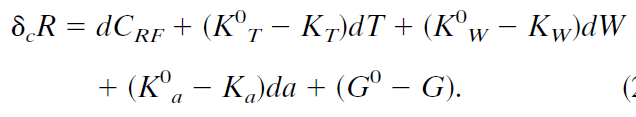

# SOM Equilibrium

Winter

In [35]:
#SOM CRE
w_F = w_som_net_asr_control - w_som_net_olr_control #control forcing all-sky
w_Fc = w_som_c_net_asr_control - w_som_c_net_olr_control #control forcing clearsky

#print(somc)

w_CRE = w_F-w_Fc #net CRE som Control

w_F_2xCO2 = w_som_net_asr_CO2 - w_som_net_olr_CO2 #control forcing all-sky
w_Fc_2xCO2 = w_som_c_net_asr_CO2 - w_som_c_net_olr_CO2 #control forcing clearsky

w_CRE_2xCO2 = w_F_2xCO2-w_Fc_2xCO2 #CRE after 2xCO2

w_DCRE = w_CRE_2xCO2 - w_CRE #change in CRE
w_DCRE_gm = globalMean(w_DCRE)

Spring

In [36]:
#SOM CRE
sp_F = sp_som_net_asr_control - sp_som_net_olr_control #control forcing all-sky
sp_Fc = sp_som_c_net_asr_control - sp_som_c_net_olr_control #control forcing clearsky

#print(somc)

sp_CRE = sp_F-sp_Fc #net CRE som Control

sp_F_2xCO2 = sp_som_net_asr_CO2 - sp_som_net_olr_CO2 #control forcing all-sky
sp_Fc_2xCO2 = sp_som_c_net_asr_CO2 - sp_som_c_net_olr_CO2 #control forcing clearsky

sp_CRE_2xCO2 = sp_F_2xCO2-sp_Fc_2xCO2 #CRE after 2xCO2

sp_DCRE = sp_CRE_2xCO2 - sp_CRE #change in CRE
sp_DCRE_gm = globalMean(sp_DCRE)

Summer

In [37]:
#SOM CRE
su_F = su_som_net_asr_control - su_som_net_olr_control #control forcing all-sky
su_Fc = su_som_c_net_asr_control - su_som_c_net_olr_control #control forcing clearsky

#print(somc)

su_CRE = su_F-su_Fc #net CRE som Control

su_F_2xCO2 = su_som_net_asr_CO2 - su_som_net_olr_CO2 #control forcing all-sky
su_Fc_2xCO2 = su_som_c_net_asr_CO2 - su_som_c_net_olr_CO2 #control forcing clearsky

su_CRE_2xCO2 = su_F_2xCO2-su_Fc_2xCO2 #CRE after 2xCO2

su_DCRE = su_CRE_2xCO2 - su_CRE #change in CRE
su_DCRE_gm = globalMean(su_DCRE)

Fall

In [38]:
#SOM CRE
f_F = f_som_net_asr_control - f_som_net_olr_control #control forcing all-sky
f_Fc = f_som_c_net_asr_control - f_som_c_net_olr_control #control forcing clearsky

#print(somc)

f_CRE = f_F-f_Fc #net CRE som Control

f_F_2xCO2 = f_som_net_asr_CO2 - f_som_net_olr_CO2 #control forcing all-sky
f_Fc_2xCO2 = f_som_c_net_asr_CO2 - f_som_c_net_olr_CO2 #control forcing clearsky

f_CRE_2xCO2 = f_F_2xCO2-f_Fc_2xCO2 #CRE after 2xCO2

f_DCRE = f_CRE_2xCO2 - f_CRE #change in CRE
f_DCRE_gm = globalMean(f_DCRE)

In [39]:
print('winter: ',w_DCRE_gm)
print('spring: ',sp_DCRE_gm)
print('summer: ',su_DCRE_gm)
print('fall: ',f_DCRE_gm)

winter:  <xarray.DataArray ()>
array(-1.31655)
spring:  <xarray.DataArray ()>
array(-0.875418)
summer:  <xarray.DataArray ()>
array(-0.376741)
fall:  <xarray.DataArray ()>
array(-0.671217)


## Globally averaged surface temperature

Winter

In [40]:
#T
#sets up change in global surface temperature for both cesm models
w_som_net_T_control = atm['som_control'].TREFHT.isel(time=slice(-(10*12+1),-1))[wn].mean(axis=0)
w_som_net_T_CO2 = atm['som_2xCO2'].TREFHT.isel(time=slice(-(10*12+1),-1))[wn].mean(axis=0)

w_cpl_net_T_control = atm['cpl_control'].TREFHT.isel(time=slice(-(20*12+1),-1))[wc].mean(axis=0)
w_cpl_net_T_CO2 = atm['cpl_CO2ramp'].TREFHT.isel(time=slice(-(20*12+1),-1))[wc].mean(axis=0)

w_DT = w_som_net_T_CO2 - w_som_net_T_control
w_DT_gm = float(globalMean(w_DT))

w_cpl_DT = w_cpl_net_T_CO2 - w_cpl_net_T_control
w_cpl_DT_gm = float(globalMean(w_cpl_DT))

Spring

In [41]:
#T
#sets up change in global surface temperature for both cesm models
sp_som_net_T_control = atm['som_control'].TREFHT.isel(time=slice(-(10*12+1),-1))[spn].mean(axis=0)
sp_som_net_T_CO2 = atm['som_2xCO2'].TREFHT.isel(time=slice(-(10*12+1),-1))[spn].mean(axis=0)

sp_cpl_net_T_control = atm['cpl_control'].TREFHT.isel(time=slice(-(20*12+1),-1))[spc].mean(axis=0)
sp_cpl_net_T_CO2 = atm['cpl_CO2ramp'].TREFHT.isel(time=slice(-(20*12+1),-1))[spc].mean(axis=0)

#slab ocean model
sp_DT = sp_som_net_T_CO2 - sp_som_net_T_control
sp_DT_gm = float(globalMean(sp_DT))

#copled model
sp_cpl_DT = sp_cpl_net_T_CO2 - sp_cpl_net_T_control
sp_cpl_DT_gm = float(globalMean(sp_cpl_DT))

Summer

In [42]:
#T
#sets up change in global surface temperature for both cesm models
su_som_net_T_control = atm['som_control'].TREFHT.isel(time=slice(-(10*12+1),-1))[sun].mean(dim='time')
su_som_net_T_CO2 = atm['som_2xCO2'].TREFHT.isel(time=slice(-(10*12+1),-1))[sun].mean(dim='time')

su_cpl_net_T_control = atm['cpl_control'].TREFHT.isel(time=slice(-(20*12+1),-1))[suc].mean(dim='time')
su_cpl_net_T_CO2 = atm['cpl_CO2ramp'].TREFHT.isel(time=slice(-(20*12+1),-1))[suc].mean(dim='time')

su_DT = su_som_net_T_CO2 - su_som_net_T_control
su_DT_gm = float(globalMean(su_DT))

su_cpl_DT = su_cpl_net_T_CO2 - su_cpl_net_T_control
su_cpl_DT_gm = float(globalMean(su_cpl_DT))

Fall

In [43]:
#T
#sets up change in global surface temperature for both cesm models
f_som_net_T_control = atm['som_control'].TREFHT.isel(time=slice(-(10*12+1),-1))[fn].mean(dim='time')
f_som_net_T_CO2 = atm['som_2xCO2'].TREFHT.isel(time=slice(-(10*12+1),-1))[fn].mean(dim='time')

f_cpl_net_T_control = atm['cpl_control'].TREFHT.isel(time=slice(-(20*12+1),-1))[fc].mean(dim='time')
f_cpl_net_T_CO2 = atm['cpl_CO2ramp'].TREFHT.isel(time=slice(-(20*12+1),-1))[fc].mean(dim='time')

f_DT = f_som_net_T_CO2 - f_som_net_T_control
f_DT_gm = float(globalMean(f_DT))

f_cpl_DT = f_cpl_net_T_CO2 - f_cpl_net_T_control
f_cpl_DT_gm = float(globalMean(f_cpl_DT))

In [44]:
print("winter: ",w_DT_gm)
print("spring: ",sp_DT_gm)
print("summer: ",su_DT_gm)
print("fall: ",f_DT_gm)
print()
print("winter: ",w_cpl_DT_gm)
print("spring: ",sp_cpl_DT_gm)
print("summer: ",su_cpl_DT_gm)
print("fall: ",f_cpl_DT_gm)

winter:  2.890158306511158
spring:  2.903870494208617
summer:  2.8657311021098337
fall:  2.8918209813094387

winter:  1.8853664455226906
spring:  0.8056714116566851
summer:  1.3105042851156692
fall:  2.6500148152299787


### calculating lambdas

albedo

Winter

In [45]:
som_net_surf_sw_control = atm['som_control'].FSNS.isel(time=slice(-(10*12+1),-1))
som_net_toa_sw_control = atm['som_control'].FSNT.isel(time=slice(-(10*12+1),-1))

som_net_surf_sw_CO2 = atm['som_2xCO2'].FSNS.isel(time=slice(-(10*12+1),-1))
som_net_toa_sw_CO2 = atm['som_2xCO2'].FSNT.isel(time=slice(-(10*12+1),-1))

w_som_net_surf_sw_control = som_net_surf_sw_control[wn].mean(dim='time')
w_som_net_toa_sw_control = som_net_toa_sw_control[wn].mean(dim='time')
w_som_net_surf_sw_CO2 = som_net_surf_sw_CO2[wn].mean(dim='time')
w_som_net_toa_sw_CO2 = som_net_toa_sw_CO2[wn].mean(dim='time')

#calculates control albedo
som_albedo_control = (w_som_net_toa_sw_control-w_som_net_surf_sw_control)/w_som_net_toa_sw_control

#calculates 2xCO2 albedo
som_albedo_CO2 = (w_som_net_toa_sw_CO2-w_som_net_surf_sw_CO2)/w_som_net_toa_sw_CO2

#normalized change in albedo
dal = (som_albedo_CO2-som_albedo_control)
da=dal/(maskGlobalMean(dal,mw)/w_DT_gm)*.001

#calculate lambda and reverse sign from direction of flux
l_a = -(i_w_a_sw)*da*100 #100 is to cancel out the 100 mb in the denomenator
l_ac = -(i_w_a_sw_clr)*da*100

w_la = maskGlobalMean(l_a,mw)
w_lac = maskGlobalMean(l_ac,mw)
print(w_la)
print(w_lac)

w_a = w_lac-w_la
w_a2 = l_ac-l_a

#plt.contourf(w_a2)
#plt.colorbar()

1.2757097022786044
1.460886965072337


Spring

In [46]:
sp_som_net_surf_sw_control = som_net_surf_sw_control[spn].mean(dim='time')
sp_som_net_toa_sw_control = som_net_toa_sw_control[spn].mean(dim='time')
sp_som_net_surf_sw_CO2 = som_net_surf_sw_CO2[spn].mean(dim='time')
sp_som_net_toa_sw_CO2 = som_net_toa_sw_CO2[spn].mean(dim='time')

som_albedo_control = (sp_som_net_toa_sw_control-sp_som_net_surf_sw_control)/sp_som_net_toa_sw_control

som_albedo_CO2 = (sp_som_net_toa_sw_CO2-sp_som_net_surf_sw_CO2)/sp_som_net_toa_sw_CO2

#normalized change in albedo
dal = (som_albedo_CO2-som_albedo_control)
da=dal/(maskGlobalMean(dal,mw)/sp_DT_gm)*.001

#calculate lambda and reverse sign from direction of flux
l_a = -(i_sp_a_sw)*da*100
l_ac = -(i_sp_a_sw_clr)*da*100

sp_la = maskGlobalMean(l_a,mw)
sp_lac = maskGlobalMean(l_ac,mw)
print(sp_la)
print(sp_lac)

sp_a = sp_lac-sp_la
sp_a2 = l_ac-l_a

#plt.contourf(sp_a2)
#plt.colorbar()

0.5143248526952198
0.6382780760065286


Summer

In [47]:
su_som_net_surf_sw_control = som_net_surf_sw_control[sun].mean(dim='time')
su_som_net_toa_sw_control = som_net_toa_sw_control[sun].mean(dim='time')
su_som_net_surf_sw_CO2 = som_net_surf_sw_CO2[sun].mean(dim='time')
su_som_net_toa_sw_CO2 = som_net_toa_sw_CO2[sun].mean(dim='time')

som_albedo_control = (su_som_net_toa_sw_control-su_som_net_surf_sw_control)/su_som_net_toa_sw_control

som_albedo_CO2 = (su_som_net_toa_sw_CO2-su_som_net_surf_sw_CO2)/su_som_net_toa_sw_CO2

#normalized change in albedo
dal = (som_albedo_CO2-som_albedo_control)
da=dal/(maskGlobalMean(dal,mw)/su_DT_gm)*.001

#calculate lambda and reverse sign from direction of flux
l_a = -(i_su_a_sw)*da*100
l_ac = -(i_su_a_sw_clr)*da*100

su_la = maskGlobalMean(l_a,mw)
su_lac = maskGlobalMean(l_ac,mw)
print(su_la)
print(su_lac)

su_a = su_lac-su_la
su_a2 = l_ac-l_a

#plt.contourf(su_a2)
#plt.colorbar()

4.463990030724693
5.082989314823426


Fall

In [48]:
f_som_net_surf_sw_control = som_net_surf_sw_control[fn].mean(dim='time')
f_som_net_toa_sw_control = som_net_toa_sw_control[fn].mean(dim='time')
f_som_net_surf_sw_CO2 = som_net_surf_sw_CO2[fn].mean(dim='time')
f_som_net_toa_sw_CO2 = som_net_toa_sw_CO2[fn].mean(dim='time')

som_albedo_control = (f_som_net_toa_sw_control-f_som_net_surf_sw_control)/f_som_net_toa_sw_control

som_albedo_CO2 = (f_som_net_toa_sw_CO2-f_som_net_surf_sw_CO2)/f_som_net_toa_sw_CO2

#normalized change in albedo
dal = (som_albedo_CO2-som_albedo_control)
da=dal/(maskGlobalMean(dal,mw)/f_DT_gm)*.001

#calculate lambda and reverse sign from direction of flux
l_a = -(i_f_a_sw)*da*100
l_ac = -(i_f_a_sw_clr)*da*100

f_la = maskGlobalMean(l_a,mw)
f_lac = maskGlobalMean(l_ac,mw)
print(f_la)
print(f_lac)

f_a = f_lac-f_la
f_a2 = l_ac-l_a

#plt.contourf(f_a2)
#plt.colorbar()

0.8272689860837722
0.844280711618451


temperature

Winter

In [49]:
som_net_Tel_control = atm['som_control'].T.isel(time=slice(-(10*12+1),-1))
som_net_Tel_CO2 = atm['som_2xCO2'].T.isel(time=slice(-(10*12+1),-1))

w_som_net_Tel_control = som_net_Tel_control[wn].mean(dim='time')
w_som_net_Tel_CO2 = som_net_Tel_CO2[wn].mean(dim='time')

#2d T array (lev,lat)
som_net_Tel_control_lev = np.average(w_som_net_Tel_control,axis=2)
som_net_Tel_CO2_lev = np.average(w_som_net_Tel_CO2,axis=2)

#2D T array (lat,lon)
som_net_Tel_control_surf = np.average(w_som_net_Tel_control,axis=0,weights=lw)
som_net_Tel_CO2_surf = np.average(w_som_net_Tel_CO2,axis=0, weights = lw)

dtl=(som_net_Tel_CO2_lev-som_net_Tel_control_lev)
dts=(som_net_Tel_CO2_surf-som_net_Tel_control_surf)
DT_lev = dtl/(globalMeanInterp(dtl,mw,lw)/w_DT_gm*26) #26 is to turn the average into the sum of the layers
DT_surf = dts/(maskGlobalMean(dts,mw)/w_DT_gm*26)     #there is 26 layers in the model

#(lev,lat)
l_pc = DT_lev*(w_plat_p_lw_clr)*100
l_p = DT_lev*(w_plat_p_lw)*100

l_pc_surf = DT_surf*(w_plon_p_lw_clr)*100
l_p_surf = DT_surf*(w_plon_p_lw)*100

lp = -globalMeanInterp(l_p,mw,lw)
lpc = -globalMeanInterp(l_pc,mw,lw)

lp2 = -maskGlobalMean(l_p_surf,mw)
lpc2 = -maskGlobalMean(l_pc_surf,mw)

print(lpc)
print(lp)
print(lpc2)
print(lp2)

w_p = lpc-lp
w_p2 = l_pc_surf-l_p_surf

#plt.contourf(w_p2)
#plt.colorbar()

-5.624351009152564
-7.141285852670157
-5.766442578432936
-6.343293752767055


Spring

In [50]:
sp_som_net_Tel_control = som_net_Tel_control[spn].mean(dim='time')
sp_som_net_Tel_CO2 = som_net_Tel_CO2[spn].mean(dim='time')

#2d T array (lev,lat)
som_net_Tel_control_lev = np.average(sp_som_net_Tel_control,axis=2)
som_net_Tel_CO2_lev = np.average(sp_som_net_Tel_CO2,axis=2)

#2D T array (lat,lon)
som_net_Tel_control_surf = np.average(sp_som_net_Tel_control,axis=0,weights=lw)
som_net_Tel_CO2_surf = np.average(sp_som_net_Tel_CO2,axis=0, weights = lw)

dtl=(som_net_Tel_CO2_lev-som_net_Tel_control_lev)
dts=(som_net_Tel_CO2_surf-som_net_Tel_control_surf)
DT_lev = dtl/(globalMeanInterp(dtl,mw,lw)/sp_DT_gm*26)
DT_surf = dts/(maskGlobalMean(dts,mw)/sp_DT_gm*26)

#(lev,lat)
l_pc = DT_lev*(sp_plat_p_lw_clr)*100
l_p = DT_lev*(sp_plat_p_lw)*100

l_pc_surf = DT_surf*(sp_plon_p_lw_clr)*100
l_p_surf = DT_surf*(sp_plon_p_lw)*100

lp = -globalMeanInterp(l_p,mw,lw)
lpc = -globalMeanInterp(l_pc,mw,lw)

lp2 = -maskGlobalMean(l_p_surf,mw)
lpc2 = -maskGlobalMean(l_pc_surf,mw)

print(lpc)
print(lp)
print(lpc2)
print(lp2)

sp_p = lpc-lp
sp_p2 = l_pc_surf-l_p_surf

#plt.contourf(sp_p2)
#plt.colorbar()

-2.8229116442678404
-3.5212788229793532
-2.8658293861953585
-3.158458100867434


Summer

In [51]:
su_som_net_Tel_control = som_net_Tel_control[sun].mean(dim='time')
su_som_net_Tel_CO2 = som_net_Tel_CO2[sun].mean(dim='time')

#2d T array (lev,lat)
som_net_Tel_control_lev = np.average(su_som_net_Tel_control,axis=2)
som_net_Tel_CO2_lev = np.average(su_som_net_Tel_CO2,axis=2)

#2D T array (lat,lon)
som_net_Tel_control_surf = np.average(su_som_net_Tel_control,axis=0,weights=lw)
som_net_Tel_CO2_surf = np.average(su_som_net_Tel_CO2,axis=0, weights = lw)

dtl=(som_net_Tel_CO2_lev-som_net_Tel_control_lev)
dts=(som_net_Tel_CO2_surf-som_net_Tel_control_surf)
DT_lev = dtl/(globalMeanInterp(dtl,mw,lw)/su_DT_gm*26)
DT_surf = dts/(maskGlobalMean(dts,mw)/su_DT_gm*26)

#(lev,lat)
l_pc = DT_lev*(su_plat_p_lw_clr)*100
l_p = DT_lev*(su_plat_p_lw)*100

l_pc_surf = DT_surf*(su_plon_p_lw_clr)*100
l_p_surf = DT_surf*(su_plon_p_lw)*100

lp = -globalMeanInterp(l_p,mw,lw)
lpc = -globalMeanInterp(l_pc,mw,lw)

lp2 = -maskGlobalMean(l_p_surf,mw)
lpc2 = -maskGlobalMean(l_pc_surf,mw)

print(lpc)
print(lp)
print(lpc2)
print(lp2)

su_p = lpc-lp
su_p2 = l_pc_surf-l_p_surf

#plt.contourf(su_p2)
#plt.colorbar()

-2.9421928056867612
-3.578547588807463
-2.85784777752358
-3.125273562981544


Fall

In [52]:
f_som_net_Tel_control = som_net_Tel_control[fn].mean(dim='time')
f_som_net_Tel_CO2 = som_net_Tel_CO2[fn].mean(dim='time')

#2d T array (lev,lat)
som_net_Tel_control_lev = np.average(f_som_net_Tel_control,axis=2)
som_net_Tel_CO2_lev = np.average(f_som_net_Tel_CO2,axis=2)

#2D T array (lat,lon)
som_net_Tel_control_surf = np.average(f_som_net_Tel_control,axis=0,weights=lw)
som_net_Tel_CO2_surf = np.average(f_som_net_Tel_CO2,axis=0, weights = lw)

dtl=(som_net_Tel_CO2_lev-som_net_Tel_control_lev)
dts=(som_net_Tel_CO2_surf-som_net_Tel_control_surf)
DT_lev = dtl/(globalMeanInterp(dtl,mw,lw)/f_DT_gm*26)
DT_surf = dts/(maskGlobalMean(dts,mw)/f_DT_gm*26)

#(lev,lat)
l_pc = DT_lev*(f_plat_p_lw_clr)*100
l_p = DT_lev*(f_plat_p_lw)*100

l_pc_surf = DT_surf*(f_plon_p_lw_clr)*100
l_p_surf = DT_surf*(f_plon_p_lw)*100

lp = -globalMeanInterp(l_p,mw,lw)
lpc = -globalMeanInterp(l_pc,mw,lw)

lp2 = -maskGlobalMean(l_p_surf,mw)
lpc2 = -maskGlobalMean(l_pc_surf,mw)

print(lpc)
print(lp)
print(lpc2)
print(lp2)

f_p = lpc-lp
f_p2 = l_pc_surf-l_p_surf

#plt.contourf(f_p2)
#plt.colorbar()

-2.8254035923668632
-3.502910988736649
-2.83030125355091
-3.1174420533162537


water vapor

Winter

In [53]:
som_q_control = atm['som_control'].Q.isel(time=slice(-(10*12+1),-1))
w_som_q_control = som_q_control[wn].mean(dim='time')

ave_som_q_control = np.average(w_som_q_control,axis=2) 
lev_ave_som_q_control = np.average(w_som_q_control,axis=0,weights=lw) 

som_q_CO2 = atm['som_2xCO2'].Q.isel(time=slice(-(10*12+1),-1))
w_som_q_CO2 = som_q_CO2[wn].mean(dim='time')

ave_som_q_CO2 = np.average(w_som_q_CO2,axis=2) 
lev_ave_som_q_CO2 = np.average(w_som_q_CO2,axis=0,weights=lw) 

#print("2xCO2 SH: ",ave_som_q_CO2)

dq=(np.log(ave_som_q_CO2)-np.log(ave_som_q_control))
dqs=(np.log(lev_ave_som_q_CO2)-np.log(lev_ave_som_q_control))
dq_lev=dq/(globalMeanInterp(dq,mw,lw)/w_DT_gm*26)
dq_surf=dqs/(maskGlobalMean(dqs,mw)/w_DT_gm*26)

##specific humidity
l_q_sw = dq_lev*(w_plat_wv_sw)*100
l_qc_sw = dq_lev*(w_plat_wv_sw_clr)*100
l_q_lw = dq_lev*(w_plat_wv_lw)*100
l_qc_lw = dq_lev*(w_plat_wv_lw_clr)*100

print("l_q_sw: ",globalMeanInterp(l_q_sw,mw,lw))
print("l_qc_sw: ",globalMeanInterp(l_qc_sw,mw,lw))
print("l_q_lw: ",globalMeanInterp(l_q_lw,mw,lw))
print("l_qc_lw: ",globalMeanInterp(l_qc_lw,mw,lw))

ml_qc_sw = globalMeanInterp(l_qc_sw,mw,lw)
ml_q_sw = globalMeanInterp(l_q_sw,mw,lw)
ml_qc_lw = globalMeanInterp(l_qc_lw,mw,lw)
ml_q_lw = globalMeanInterp(l_q_lw,mw,lw)

qlw = (ml_qc_lw-ml_q_lw)
qsw = (ml_qc_sw-ml_q_sw)

w_q = -qlw + qsw

l_q_sw_surf = dq_surf*(w_plon_wv_sw)*100
l_qc_sw_surf = dq_surf*(w_plon_wv_sw_clr)*100
l_q_lw_surf = dq_surf*(w_plon_wv_lw)*100
l_qc_lw_surf = dq_surf*(w_plon_wv_lw_clr)*100

qlw2 = (l_qc_lw_surf-l_q_lw_surf)
qsw2 = (l_qc_sw_surf-l_q_sw_surf)

w_q2 = -qlw2 + qsw2
#plt.contourf(w_q2)
#plt.colorbar()

w_ave_qlw2 = maskGlobalMean(l_q_lw_surf,mw)
print(w_ave_qlw2)


l_q_sw:  0.3526382559711578
l_qc_sw:  0.21012184776683307
l_q_lw:  -2.752895505838573
l_qc_lw:  -3.6187091193610414
-1.9128639611633325


Spring

In [54]:
som_q_control = atm['som_control'].Q.isel(time=slice(-(10*12+1),-1))
sp_som_q_control = som_q_control[spn].mean(dim='time')

ave_som_q_control = np.average(sp_som_q_control,axis=2) 
lev_ave_som_q_control = np.average(sp_som_q_control,axis=0,weights=lw) 

som_q_CO2 = atm['som_2xCO2'].Q.isel(time=slice(-(10*12+1),-1))
sp_som_q_CO2 = som_q_CO2[spn].mean(dim='time')

ave_som_q_CO2 = np.average(sp_som_q_CO2,axis=2) 
lev_ave_som_q_CO2 = np.average(sp_som_q_CO2,axis=0,weights=lw) 

dq=(np.log(ave_som_q_CO2)-np.log(ave_som_q_control))
dqs=(np.log(lev_ave_som_q_CO2)-np.log(lev_ave_som_q_control))
dq_lev=dq/(globalMeanInterp(dq,mw,lw)/sp_DT_gm*26)
dq_surf=dqs/(maskGlobalMean(dqs,mw)/sp_DT_gm*26)

##specific humidity
l_q_sw = dq_lev*(sp_plat_wv_sw)*100
l_qc_sw = dq_lev*(sp_plat_wv_sw_clr)*100
l_q_lw = dq_lev*(sp_plat_wv_lw)*100
l_qc_lw = dq_lev*(sp_plat_wv_lw_clr)*100

print("l_q_sw: ",globalMeanInterp(l_q_sw,mw,lw))
print("l_qc_sw: ",globalMeanInterp(l_qc_sw,mw,lw))
print("l_q_lw: ",globalMeanInterp(l_q_lw,mw,lw))
print("l_qc_lw: ",globalMeanInterp(l_qc_lw,mw,lw))

ml_qc_sw = globalMeanInterp(l_qc_sw,mw,lw)
ml_q_sw = globalMeanInterp(l_q_sw,mw,lw)
ml_qc_lw = globalMeanInterp(l_qc_lw,mw,lw)
ml_q_lw = globalMeanInterp(l_q_lw,mw,lw)

qlw = (ml_qc_lw-ml_q_lw)
qsw = (ml_qc_sw-ml_q_sw)

sp_q = -qlw + qsw

l_q_sw_surf = dq_surf*(sp_plon_wv_sw)*100
l_qc_sw_surf = dq_surf*(sp_plon_wv_sw_clr)*100
l_q_lw_surf = dq_surf*(sp_plon_wv_lw)*100
l_qc_lw_surf = dq_surf*(sp_plon_wv_lw_clr)*100

qlw2 = (l_qc_lw_surf-l_q_lw_surf)
qsw2 = (l_qc_sw_surf-l_q_sw_surf)

sp_q2 = -qlw2 + qsw2
#plt.contourf(sp_q2)
#plt.colorbar()

sp_ave_qlw2 = maskGlobalMean(l_q_lw_surf,mw)
print(sp_ave_qlw2)

l_q_sw:  0.16907210117286048
l_qc_sw:  0.11814899558975989
l_q_lw:  -1.3735492588752605
l_qc_lw:  -1.8056737809176586
-0.9729231540691292


Summer

In [55]:
som_q_control = atm['som_control'].Q.isel(time=slice(-(10*12+1),-1))
su_som_q_control = som_q_control[sun].mean(dim='time')

ave_som_q_control = np.average(su_som_q_control,axis=2) 
lev_ave_som_q_control = np.average(su_som_q_control,axis=0,weights=lw) 

som_q_CO2 = atm['som_2xCO2'].Q.isel(time=slice(-(10*12+1),-1))
su_som_q_CO2 = som_q_CO2[wn].mean(dim='time')

ave_som_q_CO2 = np.average(su_som_q_CO2,axis=2) 
lev_ave_som_q_CO2 = np.average(su_som_q_CO2,axis=0,weights=lw) 

dq=(np.log(ave_som_q_CO2)-np.log(ave_som_q_control))
dqs=(np.log(lev_ave_som_q_CO2)-np.log(lev_ave_som_q_control))
dq_lev=dq/(globalMeanInterp(dq,mw,lw)/su_DT_gm*26)
dq_surf=dqs/(maskGlobalMean(dqs,mw)/su_DT_gm*26)

##specific humidity
l_q_sw = dq_lev*(su_plat_wv_sw)*100
l_qc_sw = dq_lev*(su_plat_wv_sw_clr)*100
l_q_lw = dq_lev*(su_plat_wv_lw)*100
l_qc_lw = dq_lev*(su_plat_wv_lw_clr)*100

print("l_q_sw: ",globalMeanInterp(l_q_sw,mw,lw))
print("l_qc_sw: ",globalMeanInterp(l_qc_sw,mw,lw))
print("l_q_lw: ",globalMeanInterp(l_q_lw,mw,lw))
print("l_qc_lw: ",globalMeanInterp(l_qc_lw,mw,lw))

ml_qc_sw = globalMeanInterp(l_qc_sw,mw,lw)
ml_q_sw = globalMeanInterp(l_q_sw,mw,lw)
ml_qc_lw = globalMeanInterp(l_qc_lw,mw,lw)
ml_q_lw = globalMeanInterp(l_q_lw,mw,lw)

qlw = (ml_qc_lw-ml_q_lw)
qsw = (ml_qc_sw-ml_q_sw)

su_q = -qlw + qsw

l_q_sw_surf = dq_surf*(su_plon_wv_sw)*100
l_qc_sw_surf = dq_surf*(su_plon_wv_sw_clr)*100
l_q_lw_surf = dq_surf*(su_plon_wv_lw)*100
l_qc_lw_surf = dq_surf*(su_plon_wv_lw_clr)*100

qlw2 = (l_qc_lw_surf-l_q_lw_surf)
qsw2 = (l_qc_sw_surf-l_q_sw_surf)

su_q2 = -qlw2 + qsw2
#plt.contourf(w_q2)
#plt.colorbar()

su_ave_qlw2 = maskGlobalMean(l_q_lw_surf,mw)
print(su_ave_qlw2)

l_q_sw:  -0.1415978027172157
l_qc_sw:  -0.12610802916896136
l_q_lw:  -1.2047442826128898
l_qc_lw:  -1.4463177736743291
-0.7019625582382949


Fall

In [56]:
som_q_control = atm['som_control'].Q.isel(time=slice(-(10*12+1),-1))
f_som_q_control = som_q_control[fn].mean(dim='time')

ave_som_q_control = np.average(f_som_q_control,axis=2) 
lev_ave_som_q_control = np.average(f_som_q_control,axis=0,weights=lw) 

som_q_CO2 = atm['som_2xCO2'].Q.isel(time=slice(-(10*12+1),-1))
f_som_q_CO2 = som_q_CO2[wn].mean(dim='time')

ave_som_q_CO2 = np.average(f_som_q_CO2,axis=2) 
lev_ave_som_q_CO2 = np.average(f_som_q_CO2,axis=0,weights=lw) 

dq=(np.log(ave_som_q_CO2)-np.log(ave_som_q_control))
dqs=(np.log(lev_ave_som_q_CO2)-np.log(lev_ave_som_q_control))
dq_lev=dq/(globalMeanInterp(dq,mw,lw)/f_DT_gm*26)
dq_surf=dqs/(maskGlobalMean(dqs,mw)/f_DT_gm*26)

##specific humidity
l_q_sw = dq_lev*(f_plat_wv_sw)*100
l_qc_sw = dq_lev*(f_plat_wv_sw_clr)*100
l_q_lw = dq_lev*(f_plat_wv_lw)*100
l_qc_lw = dq_lev*(f_plat_wv_lw_clr)*100

print("l_q_sw: ",globalMeanInterp(l_q_sw,mw,lw))
print("l_qc_sw: ",globalMeanInterp(l_qc_sw,mw,lw))
print("l_q_lw: ",globalMeanInterp(l_q_lw,mw,lw))
print("l_qc_lw: ",globalMeanInterp(l_qc_lw,mw,lw))

ml_qc_sw = globalMeanInterp(l_qc_sw,mw,lw)
ml_q_sw = globalMeanInterp(l_q_sw,mw,lw)
ml_qc_lw = globalMeanInterp(l_qc_lw,mw,lw)
ml_q_lw = globalMeanInterp(l_q_lw,mw,lw)

qlw = (ml_qc_lw-ml_q_lw)
qsw = (ml_qc_sw-ml_q_sw)

f_q = -qlw + qsw

l_q_sw_surf = dq_surf*(f_plon_wv_sw)*100
l_qc_sw_surf = dq_surf*(f_plon_wv_sw_clr)*100
l_q_lw_surf = dq_surf*(f_plon_wv_lw)*100
l_qc_lw_surf = dq_surf*(f_plon_wv_lw_clr)*100

qlw2 = (l_qc_lw_surf-l_q_lw_surf)
qsw2 = (l_qc_sw_surf-l_q_sw_surf)

f_q2 = -qlw2 + qsw2
#plt.contourf(w_q2)
#plt.colorbar()

f_ave_qlw2 = maskGlobalMean(l_q_lw_surf,mw)
print(f_ave_qlw2)

l_q_sw:  0.17376408073437108
l_qc_sw:  0.11177738764263756
l_q_lw:  -1.4123362518114644
l_qc_lw:  -1.7042681008325926
-1.1216167737288678


In [57]:
##mask poles
#poles are in flux due to ice creation and melting. The mask is not enough to remove these factors
mask=np.meshgrid(mlat)
mask = np.array(mask)
mask[mask>55] = np.nan
mask[mask<-55] = np.nan
mask = np.meshgrid(mlon,mask)

/kt11/ktyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [58]:
print('winter')
print('term1: ',w_DCRE_gm/w_DT_gm)
print('term2: ',w_a)
print('term3: ',w_p)
print('term4: ',w_q)
w_l_c = (w_DCRE_gm/w_DT_gm) - w_a + w_p + w_q
print('l_c: ',w_l_c)
print()
print('spring')
print('term1: ',sp_DCRE_gm/sp_DT_gm)
print('term2: ',sp_a)
print('term3: ',sp_p)
print('term4: ',sp_q)
sp_l_c = (sp_DCRE_gm/sp_DT_gm) - sp_a + sp_p + sp_q
print('l_c: ',sp_l_c)
print()
print('summer')
print('term1: ',su_DCRE_gm/su_DT_gm)
print('term2: ',su_a)
print('term3: ',su_p)
print('term4: ',su_q)
su_l_c = (su_DCRE_gm/su_DT_gm) - su_a + su_p + su_q
print('l_c: ',su_l_c)
print()
print('fall')
print('term1: ',f_DCRE_gm/f_DT_gm)
print('term2: ',f_a)
print('term3: ',f_p)
print('term4: ',f_q)
f_l_c = (f_DCRE_gm/f_DT_gm) - f_a + f_p + f_q
print('l_c: ',f_l_c)

winter
term1:  <xarray.DataArray ()>
array(-0.455529)
term2:  0.1851772627937327
term3:  1.5169348435175927
term4:  0.7232972053181439
l_c:  <xarray.DataArray ()>
array(1.599526)

spring
term1:  <xarray.DataArray ()>
array(-0.301466)
term2:  0.12395322331130887
term3:  0.6983671787115129
term4:  0.38120141645929756
l_c:  <xarray.DataArray ()>
array(0.65415)

summer
term1:  <xarray.DataArray ()>
array(-0.131464)
term2:  0.6189992840987335
term3:  0.6363547831207019
term4:  0.25706326460969364
l_c:  <xarray.DataArray ()>
array(0.142955)

fall
term1:  <xarray.DataArray ()>
array(-0.232109)
term2:  0.01701172553467878
term3:  0.6775073963697857
term4:  0.2299451559293947
l_c:  <xarray.DataArray ()>
array(0.658332)


term1:  <xarray.DataArray ()>
array(-0.795683)
term2:  0.1851772627937328
term3:  -0.5768511743341189
term4:  0.6132154469524617
l_c2:  -0.6283923085453035

term1:  <xarray.DataArray ()>
array(-0.463576)
term2:  0.12395322331130877
term3:  -0.2926287146720751
term4:  0.3425620489291492
l_c2:  -0.3783441235379932

term1:  <xarray.DataArray ()>
array(-0.483016)
term2:  0.6189992840987336
term3:  -0.26742578545796386
term4:  0.08167168477483845
l_c2:  -0.9847406366597451

term1:  <xarray.DataArray ()>
array(-0.366077)
term2:  0.017011725534678675
term3:  -0.2871407997653433
term4:  0.21057352776460883
l_c2:  -0.32292540867679875



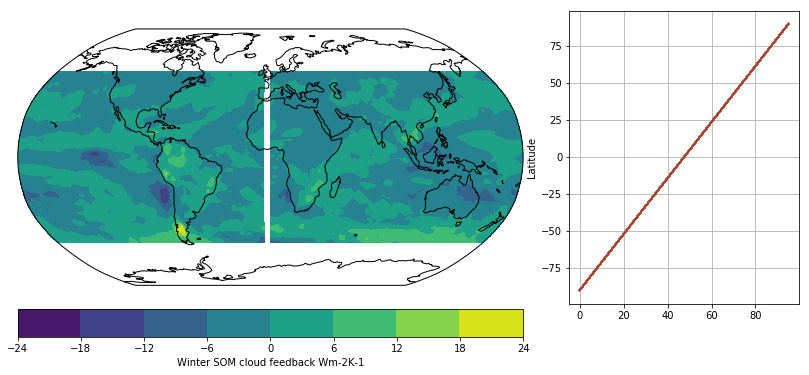

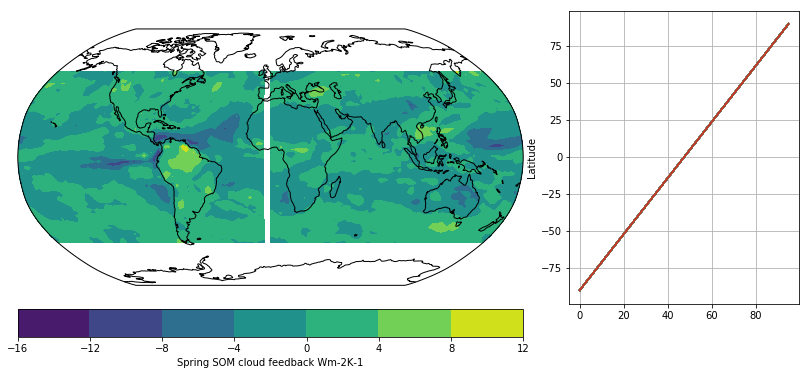

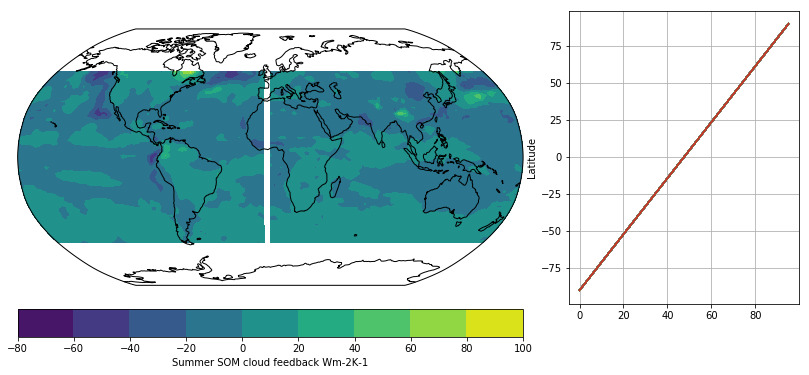

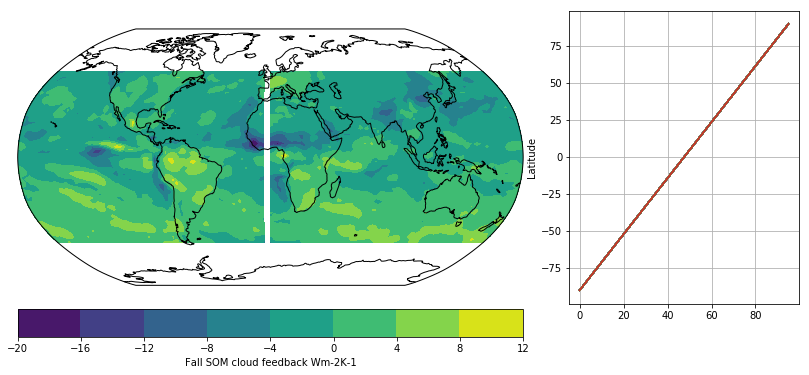

In [59]:
#averaging after calculations
l_c2 = (w_DCRE/w_DT_gm) - w_a2 + w_p2 + w_q2
print('term1: ',globalMean(w_DCRE/w_DT,mw))
print('term2: ',maskGlobalMean(w_a2,mw))
print('term3: ',maskGlobalMean(w_p2,mw))
print('term4: ',maskGlobalMean(w_q2,mw))
print('l_c2: ',maskGlobalMean(l_c2,mw))
l_c2 = np.ma.masked_array(l_c2,mask=np.isnan(mask[1]))
make_map(l_c2,'Winter SOM cloud feedback Wm-2K-1')
print()
l_c2 = (sp_DCRE/sp_DT_gm) - sp_a2 + sp_p2 + sp_q2
print('term1: ',globalMean(sp_DCRE/sp_DT,mw))
print('term2: ',maskGlobalMean(sp_a2,mw))
print('term3: ',maskGlobalMean(sp_p2,mw))
print('term4: ',maskGlobalMean(sp_q2,mw))
print('l_c2: ',maskGlobalMean(l_c2,mw))
l_c2 = np.ma.masked_array(l_c2,mask=np.isnan(mask[1]))
make_map(l_c2,'Spring SOM cloud feedback Wm-2K-1')
print()
l_c2 = (su_DCRE/su_DT_gm) - su_a2 + su_p2 + su_q2
print('term1: ',globalMean(su_DCRE/su_DT,mw))
print('term2: ',maskGlobalMean(su_a2,mw))
print('term3: ',maskGlobalMean(su_p2,mw))
print('term4: ',maskGlobalMean(su_q2,mw))
print('l_c2: ',maskGlobalMean(l_c2,mw))
l_c2 = np.ma.masked_array(l_c2,mask=np.isnan(mask[1]))
make_map(l_c2,'Summer SOM cloud feedback Wm-2K-1')
print()
l_c2 = (f_DCRE/f_DT_gm) - f_a2 + f_p2 + f_q2
print('term1: ',globalMean(f_DCRE/f_DT,mw))
print('term2: ',maskGlobalMean(f_a2,mw))
print('term3: ',maskGlobalMean(f_p2,mw))
print('term4: ',maskGlobalMean(f_q2,mw))
print('l_c2: ',maskGlobalMean(l_c2,mw))
l_c2 = np.ma.masked_array(l_c2,mask=np.isnan(mask[1]))
make_map(l_c2,'Fall SOM cloud feedback Wm-2K-1')
print()

CRE CPL

winter

In [60]:
#CRE cpl
w_cpl_F = w_cpl_net_asr_control - w_cpl_net_olr_control #forcing all-sky
w_cpl_Fc = w_cpl_c_net_asr_control - w_cpl_c_net_olr_control #forcing clearsky

w_cpl_CRE = w_cpl_F-w_cpl_Fc #net CRE som Control

w_cpl_F_2xCO2 = w_cpl_net_asr_CO2 - w_cpl_net_olr_CO2
w_cpl_Fc_2xCO2 = w_cpl_c_net_asr_CO2 - w_cpl_c_net_olr_CO2

w_cpl_CRE_2xCO2 = w_cpl_F_2xCO2-w_cpl_Fc_2xCO2 #CRE after 2xCO2

w_cpl_DCRE = w_cpl_CRE_2xCO2 - w_cpl_CRE
w_cpl_DCRE_gm = globalMean(w_cpl_DCRE)

Spring

In [61]:
sp_cpl_F = sp_cpl_net_asr_control - sp_cpl_net_olr_control #forcing all-sky
sp_cpl_Fc = sp_cpl_c_net_asr_control - sp_cpl_c_net_olr_control #forcing clearsky

sp_cpl_CRE = sp_cpl_F-sp_cpl_Fc #net CRE som Control

sp_cpl_F_2xCO2 = sp_cpl_net_asr_CO2 - sp_cpl_net_olr_CO2
sp_cpl_Fc_2xCO2 = sp_cpl_c_net_asr_CO2 - sp_cpl_c_net_olr_CO2

sp_cpl_CRE_2xCO2 = sp_cpl_F_2xCO2-sp_cpl_Fc_2xCO2 #CRE after 2xCO2

sp_cpl_DCRE = sp_cpl_CRE_2xCO2 - sp_cpl_CRE
sp_cpl_DCRE_gm = globalMean(sp_cpl_DCRE)

Summer

In [62]:
su_cpl_F = su_cpl_net_asr_control - su_cpl_net_olr_control #forcing all-sky
su_cpl_Fc = su_cpl_c_net_asr_control - su_cpl_c_net_olr_control #forcing clearsky

su_cpl_CRE = su_cpl_F-su_cpl_Fc #net CRE som Control

su_cpl_F_2xCO2 = su_cpl_net_asr_CO2 - su_cpl_net_olr_CO2
su_cpl_Fc_2xCO2 = su_cpl_c_net_asr_CO2 - su_cpl_c_net_olr_CO2

su_cpl_CRE_2xCO2 = su_cpl_F_2xCO2-su_cpl_Fc_2xCO2 #CRE after 2xCO2

su_cpl_DCRE = su_cpl_CRE_2xCO2 - su_cpl_CRE
su_cpl_DCRE_gm = globalMean(su_cpl_DCRE)

Fall

In [63]:
f_cpl_F = f_cpl_net_asr_control - f_cpl_net_olr_control #forcing all-sky
f_cpl_Fc = f_cpl_c_net_asr_control - f_cpl_c_net_olr_control #forcing clearsky

f_cpl_CRE = f_cpl_F-f_cpl_Fc #net CRE som Control

f_cpl_F_2xCO2 = f_cpl_net_asr_CO2 - f_cpl_net_olr_CO2
f_cpl_Fc_2xCO2 = f_cpl_c_net_asr_CO2 - f_cpl_c_net_olr_CO2

f_cpl_CRE_2xCO2 = f_cpl_F_2xCO2-f_cpl_Fc_2xCO2 #CRE after 2xCO2

f_cpl_DCRE = f_cpl_CRE_2xCO2 - f_cpl_CRE
f_cpl_DCRE_gm = globalMean(f_cpl_DCRE)

CPL Albedo

winter

In [64]:
cpl_net_surf_sw_control = atm['cpl_control'].FSNS.isel(time=slice(-(20*12+1),-1))
cpl_net_toa_sw_control = atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1))

w_cpl_net_surf_sw_control = cpl_net_surf_sw_control[wc].mean(dim='time')
w_cpl_net_toa_sw_control = cpl_net_toa_sw_control[wc].mean(dim='time')

cpl_albedo_control = (w_cpl_net_toa_sw_control-w_cpl_net_surf_sw_control)/w_cpl_net_toa_sw_control

cpl_net_surf_sw_CO2 = atm['cpl_CO2ramp'].FSNS.isel(time=slice(-(20*12+1),-1))
cpl_net_toa_sw_CO2 = atm['cpl_CO2ramp'].FSNT.isel(time=slice(-(20*12+1),-1))

w_cpl_net_surf_sw_CO2 = cpl_net_surf_sw_CO2[wc].mean(dim='time')
w_cpl_net_toa_sw_CO2 = cpl_net_toa_sw_CO2[wc].mean(dim='time')

cpl_albedo_CO2 = (w_cpl_net_toa_sw_CO2-w_cpl_net_surf_sw_CO2)/w_cpl_net_toa_sw_CO2

dal = (cpl_albedo_CO2-cpl_albedo_control)
da=dal/(maskGlobalMean(dal,mw)/w_cpl_DT_gm)*.001

cpl_l_a = -(i_w_a_sw)*da*100
cpl_l_ac = -(i_w_a_sw_clr)*da*100

cpl_la = maskGlobalMean(cpl_l_a,mw)
cpl_lac = maskGlobalMean(cpl_l_ac,mw)
print(cpl_la)
print(cpl_lac)

w_cpl_a = cpl_lac-cpl_la

w_cpl_a2 = cpl_l_ac-cpl_l_a

#plt.contourf(w_cpl_a2)
#plt.colorbar()

0.32669652352219114
0.4687840650272025


spring

In [65]:
cpl_net_surf_sw_control = atm['cpl_control'].FSNS.isel(time=slice(-(20*12+1),-1))
cpl_net_toa_sw_control = atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1))

sp_cpl_net_surf_sw_control = cpl_net_surf_sw_control[spc].mean(dim='time')
sp_cpl_net_toa_sw_control = cpl_net_toa_sw_control[spc].mean(dim='time')

cpl_albedo_control = (sp_cpl_net_toa_sw_control-sp_cpl_net_surf_sw_control)/sp_cpl_net_toa_sw_control

cpl_net_surf_sw_CO2 = atm['cpl_CO2ramp'].FSNS.isel(time=slice(-(20*12+1),-1))
cpl_net_toa_sw_CO2 = atm['cpl_CO2ramp'].FSNT.isel(time=slice(-(20*12+1),-1))

sp_cpl_net_surf_sw_CO2 = cpl_net_surf_sw_CO2[spc].mean(dim='time')
sp_cpl_net_toa_sw_CO2 = cpl_net_toa_sw_CO2[spc].mean(dim='time')

cpl_albedo_CO2 = (sp_cpl_net_toa_sw_CO2-sp_cpl_net_surf_sw_CO2)/sp_cpl_net_toa_sw_CO2

dal = (cpl_albedo_CO2-cpl_albedo_control)
da=dal/(maskGlobalMean(dal,mw)/sp_cpl_DT_gm)*.001

cpl_l_a = -(i_sp_a_sw)*da*100
cpl_l_ac = -(i_sp_a_sw_clr)*da*100

cpl_la = maskGlobalMean(cpl_l_a,mw)
cpl_lac = maskGlobalMean(cpl_l_ac,mw)
print(cpl_la)
print(cpl_lac)

sp_cpl_a = cpl_lac-cpl_la

sp_cpl_a2 = cpl_l_ac-cpl_l_a

#plt.contourf(sp_cpl_a2)
#plt.colorbar()

1.1739556764520755
1.7530185454307643


summer

In [66]:
cpl_net_surf_sw_control = atm['cpl_control'].FSNS.isel(time=slice(-(20*12+1),-1))
cpl_net_toa_sw_control = atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1))

su_cpl_net_surf_sw_control = cpl_net_surf_sw_control[suc].mean(dim='time')
su_cpl_net_toa_sw_control = cpl_net_toa_sw_control[suc].mean(dim='time')

cpl_albedo_control = (su_cpl_net_toa_sw_control-su_cpl_net_surf_sw_control)/su_cpl_net_toa_sw_control

cpl_net_surf_sw_CO2 = atm['cpl_CO2ramp'].FSNS.isel(time=slice(-(20*12+1),-1))
cpl_net_toa_sw_CO2 = atm['cpl_CO2ramp'].FSNT.isel(time=slice(-(20*12+1),-1))

su_cpl_net_surf_sw_CO2 = cpl_net_surf_sw_CO2[suc].mean(dim='time')
su_cpl_net_toa_sw_CO2 = cpl_net_toa_sw_CO2[suc].mean(dim='time')

cpl_albedo_CO2 = (su_cpl_net_toa_sw_CO2-su_cpl_net_surf_sw_CO2)/su_cpl_net_toa_sw_CO2

dal = (cpl_albedo_CO2-cpl_albedo_control)
da=dal/(maskGlobalMean(dal,mw)/su_cpl_DT_gm)*.001

print(globalMean(da))

cpl_l_a = -(i_su_a_sw)*da*100
cpl_l_ac = -(i_su_a_sw_clr)*da*100

cpl_la = maskGlobalMean(cpl_l_a,mw)
cpl_lac = maskGlobalMean(cpl_l_ac,mw)
print(cpl_la)
print(cpl_lac)

su_cpl_a = cpl_lac-cpl_la

su_cpl_a2 = cpl_l_ac-cpl_l_a

#plt.contourf(su_cpl_a2)
#plt.colorbar()

<xarray.DataArray ()>
array(0.001407)
0.08132004192739863
0.04391074429349942


fall

In [67]:
cpl_net_surf_sw_control = atm['cpl_control'].FSNS.isel(time=slice(-(20*12+1),-1))
cpl_net_toa_sw_control = atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1))

f_cpl_net_surf_sw_control = cpl_net_surf_sw_control[fc].mean(dim='time')
f_cpl_net_toa_sw_control = cpl_net_toa_sw_control[fc].mean(dim='time')

cpl_albedo_control = (f_cpl_net_toa_sw_control-f_cpl_net_surf_sw_control)/f_cpl_net_toa_sw_control

cpl_net_surf_sw_CO2 = atm['cpl_CO2ramp'].FSNS.isel(time=slice(-(20*12+1),-1))
cpl_net_toa_sw_CO2 = atm['cpl_CO2ramp'].FSNT.isel(time=slice(-(20*12+1),-1))

f_cpl_net_surf_sw_CO2 = cpl_net_surf_sw_CO2[fc].mean(dim='time')
f_cpl_net_toa_sw_CO2 = cpl_net_toa_sw_CO2[fc].mean(dim='time')

cpl_albedo_CO2 = (f_cpl_net_toa_sw_CO2-f_cpl_net_surf_sw_CO2)/f_cpl_net_toa_sw_CO2

dal = (cpl_albedo_CO2-cpl_albedo_control)
da=dal/(maskGlobalMean(dal,mw)/f_cpl_DT_gm)*.001

print(globalMean(da))

cpl_l_a = -(i_f_a_sw)*da*100
cpl_l_ac = -(i_f_a_sw_clr)*da*100

cpl_la = maskGlobalMean(cpl_l_a,mw)
cpl_lac = maskGlobalMean(cpl_l_ac,mw)
print(cpl_la)
print(cpl_lac)

f_cpl_a = cpl_lac-cpl_la

f_cpl_a2 = cpl_l_ac-cpl_l_a

#plt.contourf(f_cpl_a2)
#plt.colorbar()

<xarray.DataArray ()>
array(0.002649)
0.6743533557763602
0.9687782059812475


CPL T

winter

In [68]:
cpl_net_Tel_control = atm['cpl_control'].T.isel(time=slice(-(20*12+1),-1))
cpl_net_Tel_CO2 = atm['cpl_CO2ramp'].T.isel(time=slice(-(20*12+1),-1))

w_cpl_net_Tel_control = cpl_net_Tel_control[wc].mean(dim='time')
w_cpl_net_Tel_CO2 = cpl_net_Tel_CO2[wc].mean(dim='time')

#averaging (lev,lat)
cpl_net_Tel_control_lev = np.average(w_cpl_net_Tel_control,axis=2)
cpl_net_Tel_CO2_lev = np.average(w_cpl_net_Tel_CO2,axis=2)

#averaging (lat,lon)
cpl_net_Tel_control_surf = np.average(w_cpl_net_Tel_control,axis=0,weights=lw)
cpl_net_Tel_CO2_surf = np.average(w_cpl_net_Tel_CO2,axis=0,weights=lw)

dtl=(cpl_net_Tel_CO2_lev-cpl_net_Tel_control_lev)
dts=(cpl_net_Tel_CO2_surf-cpl_net_Tel_control_surf)
cpl_DT_lev = dtl/(globalMeanInterp(dtl,mw,lw)/w_cpl_DT_gm*26)
cpl_DT_surf = dts/(maskGlobalMean(dts,mw)/w_cpl_DT_gm*26)

cpl_l_pc = cpl_DT_lev*(w_plat_p_lw_clr)*100
cpl_l_p = cpl_DT_lev*(w_plat_p_lw)*100

cpl_lp = -globalMeanInterp(cpl_l_p,mw,lw)
cpl_lpc = -globalMeanInterp(cpl_l_pc,mw,lw)

print(cpl_lp)
print(cpl_lpc)

w_cpl_p = cpl_lpc-cpl_lp

cpl_l_pc2 = cpl_DT_surf*(w_plon_p_lw_clr)*100
cpl_l_p2 = cpl_DT_surf*(w_plon_p_lw)*100

w_cpl_p2 = cpl_l_pc2-cpl_l_p2

#plt.contourf(w_cpl_p2)
#plt.colorbar()

-5.201004191415273
-3.858677552875345


spring

In [69]:
cpl_net_Tel_control = atm['cpl_control'].T.isel(time=slice(-(20*12+1),-1))
cpl_net_Tel_CO2 = atm['cpl_CO2ramp'].T.isel(time=slice(-(20*12+1),-1))

sp_cpl_net_Tel_control = cpl_net_Tel_control[spc].mean(dim='time')
sp_cpl_net_Tel_CO2 = cpl_net_Tel_CO2[spc].mean(dim='time')

#averaging (lev,lat)
cpl_net_Tel_control_lev = np.average(sp_cpl_net_Tel_control,axis=2)
cpl_net_Tel_CO2_lev = np.average(sp_cpl_net_Tel_CO2,axis=2)

#averaging (lat,lon)
cpl_net_Tel_control_surf = np.average(sp_cpl_net_Tel_control,axis=0,weights=lw)
cpl_net_Tel_CO2_surf = np.average(sp_cpl_net_Tel_CO2,axis=0,weights=lw)

dtl=(cpl_net_Tel_CO2_lev-cpl_net_Tel_control_lev)
dts=(cpl_net_Tel_CO2_surf-cpl_net_Tel_control_surf)
cpl_DT_lev = dtl/(globalMeanInterp(dtl,mw,lw)/sp_cpl_DT_gm*26)
cpl_DT_surf = dts/(maskGlobalMean(dts,mw)/sp_cpl_DT_gm*26)

cpl_l_pc = cpl_DT_lev*(sp_plat_p_lw_clr)*100
cpl_l_p = cpl_DT_lev*(sp_plat_p_lw)*100

cpl_lp = -globalMeanInterp(cpl_l_p,mw,lw)
cpl_lpc = -globalMeanInterp(cpl_l_pc,mw,lw)

print(cpl_lp)
print(cpl_lpc)

sp_cpl_p = cpl_lpc-cpl_lp

cpl_l_pc2 = cpl_DT_surf*(sp_plon_p_lw_clr)*100
cpl_l_p2 = cpl_DT_surf*(sp_plon_p_lw)*100

sp_cpl_p2 = cpl_l_pc2-cpl_l_p2

#plt.contourf(sp_cpl_p2)
#plt.colorbar()

-1.0761887153595688
-0.8396917903889898


summer

In [70]:
cpl_net_Tel_control = atm['cpl_control'].T.isel(time=slice(-(20*12+1),-1))
cpl_net_Tel_CO2 = atm['cpl_CO2ramp'].T.isel(time=slice(-(20*12+1),-1))

su_cpl_net_Tel_control = cpl_net_Tel_control[suc].mean(dim='time')
su_cpl_net_Tel_CO2 = cpl_net_Tel_CO2[suc].mean(dim='time')

#averaging (lev,lat)
cpl_net_Tel_control_lev = np.average(su_cpl_net_Tel_control,axis=2)
cpl_net_Tel_CO2_lev = np.average(su_cpl_net_Tel_CO2,axis=2)

#averaging (lat,lon)
cpl_net_Tel_control_surf = np.average(su_cpl_net_Tel_control,axis=0,weights=lw)
cpl_net_Tel_CO2_surf = np.average(su_cpl_net_Tel_CO2,axis=0,weights=lw)

dtl=(cpl_net_Tel_CO2_lev-cpl_net_Tel_control_lev)
dts=(cpl_net_Tel_CO2_surf-cpl_net_Tel_control_surf)
cpl_DT_lev = dtl/(globalMeanInterp(dtl,mw,lw)/su_cpl_DT_gm*26)
cpl_DT_surf = dts/(maskGlobalMean(dts,mw)/su_cpl_DT_gm*26)

cpl_l_pc = cpl_DT_lev*(su_plat_p_lw_clr)*100
cpl_l_p = cpl_DT_lev*(su_plat_p_lw)*100

cpl_lp = -globalMeanInterp(cpl_l_p,mw,lw)
cpl_lpc = -globalMeanInterp(cpl_l_pc,mw,lw)

print(cpl_lp)
print(cpl_lpc)

su_cpl_p = cpl_lpc-cpl_lp

cpl_l_pc2 = cpl_DT_surf*(su_plon_p_lw_clr)*100
cpl_l_p2 = cpl_DT_surf*(su_plon_p_lw)*100

su_cpl_p2 = cpl_l_pc2-cpl_l_p2

#plt.contourf(su_cpl_p2)
#plt.colorbar()

-1.8579622900190265
-1.4988882232251803


fall

In [71]:
cpl_net_Tel_control = atm['cpl_control'].T.isel(time=slice(-(20*12+1),-1))
cpl_net_Tel_CO2 = atm['cpl_CO2ramp'].T.isel(time=slice(-(20*12+1),-1))

f_cpl_net_Tel_control = cpl_net_Tel_control[fc].mean(dim='time')
f_cpl_net_Tel_CO2 = cpl_net_Tel_CO2[fc].mean(dim='time')

#averaging (lev,lat)
cpl_net_Tel_control_lev = np.average(f_cpl_net_Tel_control,axis=2)
cpl_net_Tel_CO2_lev = np.average(f_cpl_net_Tel_CO2,axis=2)

#averaging (lat,lon)
cpl_net_Tel_control_surf = np.average(f_cpl_net_Tel_control,axis=0,weights=lw)
cpl_net_Tel_CO2_surf = np.average(f_cpl_net_Tel_CO2,axis=0,weights=lw)

dtl=(cpl_net_Tel_CO2_lev-cpl_net_Tel_control_lev)
dts=(cpl_net_Tel_CO2_surf-cpl_net_Tel_control_surf)
cpl_DT_lev = dtl/(globalMeanInterp(dtl,mw,lw)/f_cpl_DT_gm*26)
cpl_DT_surf = dts/(maskGlobalMean(dts,mw)/f_cpl_DT_gm*26)

cpl_l_pc = cpl_DT_lev*(f_plat_p_lw_clr)*100
cpl_l_p = cpl_DT_lev*(f_plat_p_lw)*100

cpl_lp = -globalMeanInterp(cpl_l_p,mw,lw)
cpl_lpc = -globalMeanInterp(cpl_l_pc,mw,lw)

print(cpl_lp)
print(cpl_lpc)

f_cpl_p = cpl_lpc-cpl_lp

cpl_l_pc2 = cpl_DT_surf*(f_plon_p_lw_clr)*100
cpl_l_p2 = cpl_DT_surf*(f_plon_p_lw)*100

f_cpl_p2 = cpl_l_pc2-cpl_l_p2

#plt.contourf(f_cpl_p2)
#plt.colorbar()

-3.506106191651354
-2.7741699723991315


CPL WV

winter

In [72]:
cpl_q_control = atm['cpl_control'].Q.isel(time=slice(-(20*12+1),-1))
w_cpl_q_control = cpl_q_control[wc].mean(dim='time')

ave_cpl_q_control = np.average(w_cpl_q_control,axis=2) #ave (lev,lat), surf_ave (lat,lon)
surf_ave_cpl_q_control = np.average(w_cpl_q_control,axis=0,weights=lw) 

cpl_q_CO2 = atm['cpl_CO2ramp'].Q.isel(time=slice(-(20*12+1),-1))
w_cpl_q_CO2 = cpl_q_CO2[wc].mean(dim='time')

ave_cpl_q_CO2 = np.average(w_cpl_q_CO2,axis=2) 
surf_ave_cpl_q_CO2 = np.average(w_cpl_q_CO2,axis=0,weights=lw) 

dq=(np.log(ave_cpl_q_CO2)-np.log(ave_cpl_q_control))
dqs=(np.log(surf_ave_cpl_q_CO2)-np.log(surf_ave_cpl_q_control))
dq_lev=dq/(globalMeanInterp(dq,mw,lw)/w_cpl_DT_gm*26)
dq2=dqs/(maskGlobalMean(dqs,mw)/w_cpl_DT_gm*26)

l_q_sw = dq*(w_plat_wv_sw)*100
l_qc_sw = dq*(w_plat_wv_sw_clr)*100
l_q_lw = dq*(w_plat_wv_lw)*100
l_qc_lw = dq*(w_plat_wv_lw_clr)*100

print("l_q_sw: ",globalMeanInterp(l_q_sw,mw,lw))
print("l_qc_sw: ",globalMeanInterp(l_qc_sw,mw,lw))
print("l_q_lw: ",globalMeanInterp(l_q_lw,mw,lw))
print("l_qc_lw: ",globalMeanInterp(l_qc_lw,mw,lw))

ml_qc_sw = globalMeanInterp(l_qc_sw,mw,lw)
ml_q_sw = globalMeanInterp(l_q_sw,mw,lw)
ml_qc_lw = globalMeanInterp(l_qc_lw,mw,lw)
ml_q_lw = globalMeanInterp(l_q_lw,mw,lw)

cpl_qlw = ml_qc_lw-ml_q_lw
cpl_qsw = ml_qc_sw-ml_q_sw

w_cpl_q = -cpl_qlw + cpl_qsw

l_q_sw = dq2*(w_plon_wv_sw)*100
l_qc_sw = dq2*(w_plon_wv_sw_clr)*100
l_q_lw = dq2*(w_plon_wv_lw)*100
l_qc_lw = dq2*(w_plon_wv_lw_clr)*100

cpl_qlw2 = l_qc_lw-l_q_lw
cpl_qsw2 = l_qc_sw-l_q_sw

w_cpl_q2 = -cpl_qlw2+cpl_qsw2

#plt.contourf(w_cpl_q2)
#plt.colorbar()

print('q2: ',maskGlobalMean(w_cpl_q2,mw))

l_q_sw:  0.335611281792137
l_qc_sw:  0.21004758154694386
l_q_lw:  -3.4651059986905377
l_qc_lw:  -4.574144675425829
q2:  0.4153475606930588


spring

In [73]:
cpl_q_control = atm['cpl_control'].Q.isel(time=slice(-(20*12+1),-1))
sp_cpl_q_control = cpl_q_control[spc].mean(dim='time')

ave_cpl_q_control = np.average(sp_cpl_q_control,axis=2) #ave (lev,lat), surf_ave (lat,lon)
surf_ave_cpl_q_control = np.average(sp_cpl_q_control,axis=0,weights=lw) 

cpl_q_CO2 = atm['cpl_CO2ramp'].Q.isel(time=slice(-(20*12+1),-1))
sp_cpl_q_CO2 = cpl_q_CO2[spc].mean(dim='time')

ave_cpl_q_CO2 = np.average(sp_cpl_q_CO2,axis=2) 
surf_ave_cpl_q_CO2 = np.average(sp_cpl_q_CO2,axis=0,weights=lw) 

dq=(np.log(ave_cpl_q_CO2)-np.log(ave_cpl_q_control))
dqs=(np.log(surf_ave_cpl_q_CO2)-np.log(surf_ave_cpl_q_control))
dq_lev=dq/(globalMeanInterp(dq,mw,lw)/sp_cpl_DT_gm*26)
dq2=dqs/(maskGlobalMean(dqs,mw)/sp_cpl_DT_gm*26)

l_q_sw = dq*(sp_plat_wv_sw)*100
l_qc_sw = dq*(sp_plat_wv_sw_clr)*100
l_q_lw = dq*(sp_plat_wv_lw)*100
l_qc_lw = dq*(sp_plat_wv_lw_clr)*100

print("l_q_sw: ",globalMeanInterp(l_q_sw,mw,lw))
print("l_qc_sw: ",globalMeanInterp(l_qc_sw,mw,lw))
print("l_q_lw: ",globalMeanInterp(l_q_lw,mw,lw))
print("l_qc_lw: ",globalMeanInterp(l_qc_lw,mw,lw))

ml_qc_sw = globalMeanInterp(l_qc_sw,mw,lw)
ml_q_sw = globalMeanInterp(l_q_sw,mw,lw)
ml_qc_lw = globalMeanInterp(l_qc_lw,mw,lw)
ml_q_lw = globalMeanInterp(l_q_lw,mw,lw)

cpl_qlw = ml_qc_lw-ml_q_lw
cpl_qsw = ml_qc_sw-ml_q_sw

sp_cpl_q = -cpl_qlw + cpl_qsw

l_q_sw = dq2*(sp_plon_wv_sw)*100
l_qc_sw = dq2*(sp_plon_wv_sw_clr)*100
l_q_lw = dq2*(sp_plon_wv_lw)*100
l_qc_lw = dq2*(sp_plon_wv_lw_clr)*100

cpl_qlw2 = l_qc_lw-l_q_lw
cpl_qsw2 = l_qc_sw-l_q_sw

sp_cpl_q2 = -cpl_qlw2+cpl_qsw2

#plt.contourf(sp_cpl_q2)
#plt.colorbar()

print('q2: ',maskGlobalMean(sp_cpl_q2,mw))

l_q_sw:  0.10594146381937641
l_qc_sw:  0.02873419098475378
l_q_lw:  -1.9895233425823304
l_qc_lw:  -2.5411720684432644
q2:  0.11335454513944607


summer

In [74]:
cpl_q_control = atm['cpl_control'].Q.isel(time=slice(-(20*12+1),-1))
su_cpl_q_control = cpl_q_control[suc].mean(dim='time')

ave_cpl_q_control = np.average(su_cpl_q_control,axis=2) #ave (lev,lat), surf_ave (lat,lon)
surf_ave_cpl_q_control = np.average(su_cpl_q_control,axis=0,weights=lw) 

cpl_q_CO2 = atm['cpl_CO2ramp'].Q.isel(time=slice(-(20*12+1),-1))
su_cpl_q_CO2 = cpl_q_CO2[suc].mean(dim='time')

ave_cpl_q_CO2 = np.average(su_cpl_q_CO2,axis=2) 
surf_ave_cpl_q_CO2 = np.average(su_cpl_q_CO2,axis=0,weights=lw) 

dq=(np.log(ave_cpl_q_CO2)-np.log(ave_cpl_q_control))
dqs=(np.log(surf_ave_cpl_q_CO2)-np.log(surf_ave_cpl_q_control))
dq_lev=dq/(globalMeanInterp(dq,mw,lw)/su_cpl_DT_gm*26)
dq2=dqs/(maskGlobalMean(dqs,mw)/su_cpl_DT_gm*26)

l_q_sw = dq*(su_plat_wv_sw)*100
l_qc_sw = dq*(su_plat_wv_sw_clr)*100
l_q_lw = dq*(su_plat_wv_lw)*100
l_qc_lw = dq*(su_plat_wv_lw_clr)*100

print("l_q_sw: ",globalMeanInterp(l_q_sw,mw,lw))
print("l_qc_sw: ",globalMeanInterp(l_qc_sw,mw,lw))
print("l_q_lw: ",globalMeanInterp(l_q_lw,mw,lw))
print("l_qc_lw: ",globalMeanInterp(l_qc_lw,mw,lw))

ml_qc_sw = globalMeanInterp(l_qc_sw,mw,lw)
ml_q_sw = globalMeanInterp(l_q_sw,mw,lw)
ml_qc_lw = globalMeanInterp(l_qc_lw,mw,lw)
ml_q_lw = globalMeanInterp(l_q_lw,mw,lw)

cpl_qlw = ml_qc_lw-ml_q_lw
cpl_qsw = ml_qc_sw-ml_q_sw

su_cpl_q = -cpl_qlw + cpl_qsw

l_q_sw = dq2*(su_plon_wv_sw)*100
l_qc_sw = dq2*(su_plon_wv_sw_clr)*100
l_q_lw = dq2*(su_plon_wv_lw)*100
l_qc_lw = dq2*(su_plon_wv_lw_clr)*100

cpl_qlw2 = l_qc_lw-l_q_lw
cpl_qsw2 = l_qc_sw-l_q_sw

su_cpl_q2 = -cpl_qlw2+cpl_qsw2

#plt.contourf(su_cpl_q2)
#plt.colorbar()

print('q2: ',maskGlobalMean(su_cpl_q2,mw))

l_q_sw:  0.12855811051069152
l_qc_sw:  0.062153552429442295
l_q_lw:  -1.941026513859357
l_qc_lw:  -2.477438710032138
q2:  0.14963339388962502


fall

In [75]:
cpl_q_control = atm['cpl_control'].Q.isel(time=slice(-(20*12+1),-1))
f_cpl_q_control = cpl_q_control[fc].mean(dim='time')

ave_cpl_q_control = np.average(f_cpl_q_control,axis=2) #ave (lev,lat), surf_ave (lat,lon)
surf_ave_cpl_q_control = np.average(f_cpl_q_control,axis=0,weights=lw) 

cpl_q_CO2 = atm['cpl_CO2ramp'].Q.isel(time=slice(-(20*12+1),-1))
f_cpl_q_CO2 = cpl_q_CO2[suc].mean(dim='time')

ave_cpl_q_CO2 = np.average(f_cpl_q_CO2,axis=2) 
surf_ave_cpl_q_CO2 = np.average(f_cpl_q_CO2,axis=0,weights=lw) 

dq=(np.log(ave_cpl_q_CO2)-np.log(ave_cpl_q_control))
dqs=(np.log(surf_ave_cpl_q_CO2)-np.log(surf_ave_cpl_q_control))
dq_lev=dq/(globalMeanInterp(dq,mw,lw)/f_cpl_DT_gm*26)
dq2=dqs/(maskGlobalMean(dqs,mw)/f_cpl_DT_gm*26)

l_q_sw = dq*(f_plat_wv_sw)*100
l_qc_sw = dq*(f_plat_wv_sw_clr)*100
l_q_lw = dq*(f_plat_wv_lw)*100
l_qc_lw = dq*(f_plat_wv_lw_clr)*100

print("l_q_sw: ",globalMeanInterp(l_q_sw,mw,lw))
print("l_qc_sw: ",globalMeanInterp(l_qc_sw,mw,lw))
print("l_q_lw: ",globalMeanInterp(l_q_lw,mw,lw))
print("l_qc_lw: ",globalMeanInterp(l_qc_lw,mw,lw))

ml_qc_sw = globalMeanInterp(l_qc_sw,mw,lw)
ml_q_sw = globalMeanInterp(l_q_sw,mw,lw)
ml_qc_lw = globalMeanInterp(l_qc_lw,mw,lw)
ml_q_lw = globalMeanInterp(l_q_lw,mw,lw)

cpl_qlw = ml_qc_lw-ml_q_lw
cpl_qsw = ml_qc_sw-ml_q_sw

f_cpl_q = -cpl_qlw + cpl_qsw

l_q_sw = dq2*(f_plon_wv_sw)*100
l_qc_sw = dq2*(f_plon_wv_sw_clr)*100
l_q_lw = dq2*(f_plon_wv_lw)*100
l_qc_lw = dq2*(f_plon_wv_lw_clr)*100

cpl_qlw2 = l_qc_lw-l_q_lw
cpl_qsw2 = l_qc_sw-l_q_sw

f_cpl_q2 = -cpl_qlw2+cpl_qsw2

#plt.contourf(f_cpl_q2)
#plt.colorbar()

print('q2: ',maskGlobalMean(f_cpl_q2,mw))

l_q_sw:  0.28964669080145583
l_qc_sw:  0.17947242976823835
l_q_lw:  -2.568237698806035
l_qc_lw:  -3.3912026255806262
q2:  0.2677699045011195


In [76]:
print('winter')
print('term1: ',w_cpl_DCRE_gm/w_cpl_DT_gm)
print('term2: ',w_cpl_a)
print('term3: ',w_cpl_p)
print('term4: ',w_cpl_q)
w_l_c = (w_cpl_DCRE_gm/w_cpl_DT_gm) - w_cpl_a - w_cpl_p + w_cpl_q
print('l_c: ',w_l_c)
print()
print('spring')
print('term1: ',sp_cpl_DCRE_gm/sp_cpl_DT_gm)
print('term2: ',sp_cpl_a)
print('term3: ',sp_cpl_p)
print('term4: ',sp_cpl_q)
sp_l_c = (sp_cpl_DCRE_gm/sp_cpl_DT_gm) - sp_cpl_a - sp_cpl_p + sp_cpl_q
print('l_c: ',sp_l_c)
print()
print('summer')
print('term1: ',su_cpl_DCRE_gm/su_cpl_DT_gm)
print('term2: ',su_cpl_a)
print('term3: ',su_cpl_p)
print('term4: ',su_cpl_q)
su_l_c = (su_cpl_DCRE_gm/su_cpl_DT_gm) - su_cpl_a - su_cpl_p + su_cpl_q
print('l_c: ',su_l_c)
print()
print('fall')
print('term1: ',f_cpl_DCRE_gm/f_cpl_DT_gm)
print('term2: ',f_cpl_a)
print('term3: ',f_cpl_p)
print('term4: ',f_cpl_q)
f_l_c = (f_cpl_DCRE_gm/f_cpl_DT_gm) - f_cpl_a - f_cpl_p + f_cpl_q
print('l_c: ',f_l_c)

winter
term1:  <xarray.DataArray ()>
array(0.18946)
term2:  0.14208754150501135
term3:  1.342326638539928
term4:  0.9834749764900977
l_c:  <xarray.DataArray ()>
array(-0.31148)

spring
term1:  <xarray.DataArray ()>
array(-4.679906)
term2:  0.5790628689786887
term3:  0.23649692497057906
term4:  0.4744414530263113
l_c:  <xarray.DataArray ()>
array(-5.021024)

summer
term1:  <xarray.DataArray ()>
array(0.914749)
term2:  -0.037409297633899205
term3:  0.3590740667938461
term4:  0.47000763809153157
l_c:  <xarray.DataArray ()>
array(1.063091)

fall
term1:  <xarray.DataArray ()>
array(-0.53772)
term2:  0.2944248502048873
term3:  0.7319362192522223
term4:  0.7127906657413736
l_c:  <xarray.DataArray ()>
array(-0.851291)


term1:  <xarray.DataArray ()>
array(0.189352)
term2:  0.1420875415050114
term3:  -0.3195358824926106
term4:  0.4153475606930588
l_c2:  0.16775614350577672

term1:  <xarray.DataArray ()>
array(-4.680708)
term2:  0.5790628689786886
term3:  -0.054834748374157576
term4:  0.11335454513944607
l_c2:  -5.236992959365229

term1:  <xarray.DataArray ()>
array(0.915045)
term2:  -0.0374092976338992
term3:  -0.06732584413405247
term4:  0.14963339388962502
l_c2:  1.053173468858769

term1:  <xarray.DataArray ()>
array(-0.537816)
term2:  0.29442485020488746
term3:  -0.24720758472063492
term4:  0.2677699045011195
l_c2:  -0.8087674216848576



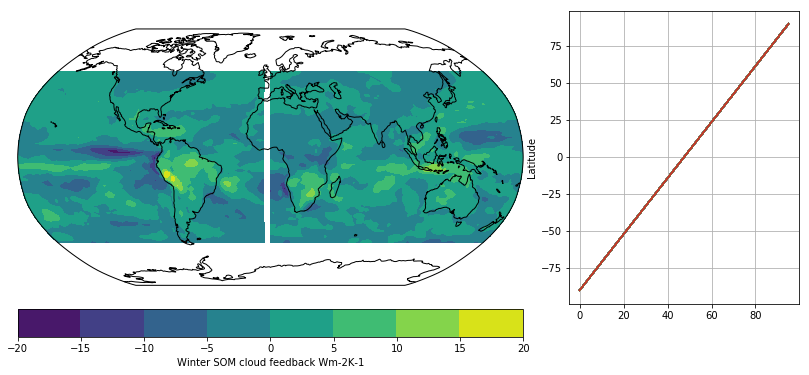

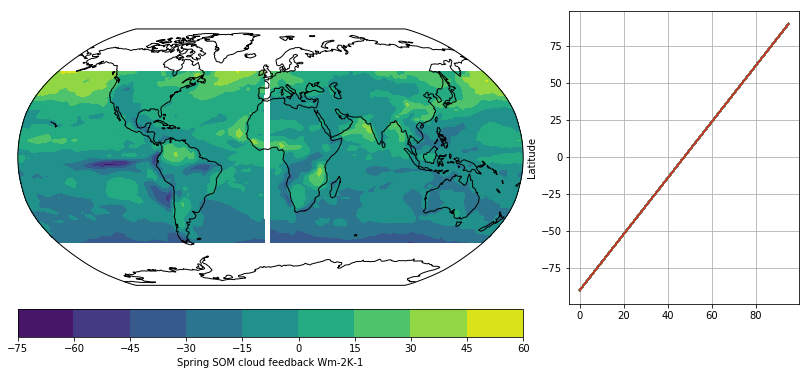

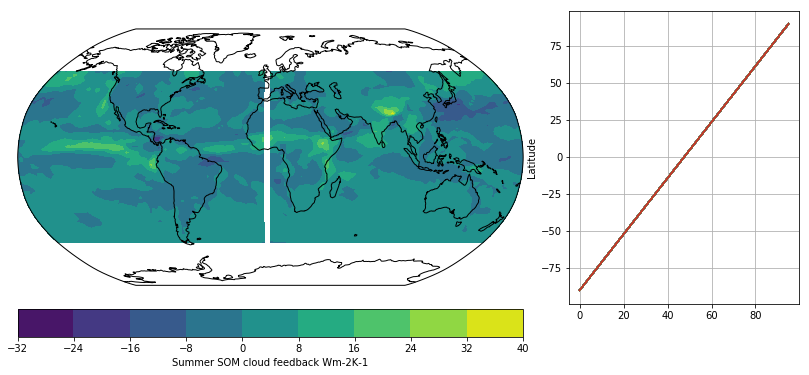

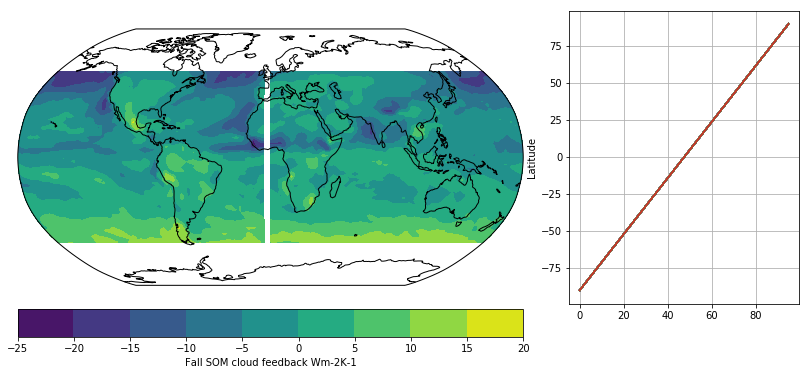

In [77]:
#averaging after calculations
l_c2 = (w_cpl_DCRE/w_cpl_DT_gm) - w_cpl_a2 + w_cpl_p2 + w_cpl_q2
print('term1: ',globalMean(w_cpl_DCRE/w_cpl_DT_gm,mw))
print('term2: ',maskGlobalMean(w_cpl_a2,mw))
print('term3: ',maskGlobalMean(w_cpl_p2,mw))
print('term4: ',maskGlobalMean(w_cpl_q2,mw))
print('l_c2: ',maskGlobalMean(l_c2,mw))
l_c2 = np.ma.masked_array(l_c2,mask=np.isnan(mask[1]))
make_map(l_c2,'Winter SOM cloud feedback Wm-2K-1')
print()
l_c2 = (sp_cpl_DCRE/sp_cpl_DT_gm) - sp_cpl_a2 + sp_cpl_p2 + sp_cpl_q2
print('term1: ',globalMean(sp_cpl_DCRE/sp_cpl_DT_gm,mw))
print('term2: ',maskGlobalMean(sp_cpl_a2,mw))
print('term3: ',maskGlobalMean(sp_cpl_p2,mw))
print('term4: ',maskGlobalMean(sp_cpl_q2,mw))
print('l_c2: ',maskGlobalMean(l_c2,mw))
l_c2 = np.ma.masked_array(l_c2,mask=np.isnan(mask[1]))
make_map(l_c2,'Spring SOM cloud feedback Wm-2K-1')
print()
l_c2 = (su_cpl_DCRE/su_cpl_DT_gm) - su_cpl_a2 + su_cpl_p2 + su_cpl_q2
print('term1: ',globalMean(su_cpl_DCRE/su_cpl_DT_gm,mw))
print('term2: ',maskGlobalMean(su_cpl_a2,mw))
print('term3: ',maskGlobalMean(su_cpl_p2,mw))
print('term4: ',maskGlobalMean(su_cpl_q2,mw))
print('l_c2: ',maskGlobalMean(l_c2,mw))
l_c2 = np.ma.masked_array(l_c2,mask=np.isnan(mask[1]))
make_map(l_c2,'Summer SOM cloud feedback Wm-2K-1')
print()
l_c2 = (f_cpl_DCRE/f_cpl_DT_gm) - f_cpl_a2 + f_cpl_p2 + f_cpl_q2
print('term1: ',globalMean(f_cpl_DCRE/f_cpl_DT_gm,mw))
print('term2: ',maskGlobalMean(f_cpl_a2,mw))
print('term3: ',maskGlobalMean(f_cpl_p2,mw))
print('term4: ',maskGlobalMean(f_cpl_q2,mw))
print('l_c2: ',maskGlobalMean(l_c2,mw))
l_c2 = np.ma.masked_array(l_c2,mask=np.isnan(mask[1]))
make_map(l_c2,'Fall SOM cloud feedback Wm-2K-1')
print()